In [560]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier

from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
import sys

sys.path.append('../../')
from RF_atomver import *

In [578]:
max_cols = ['accuracy', 'precision', 'recall', 'specificity',
       'TN',  'TP', 'ROC-AUC', 'MCC', 'Balanced Accuracy','f1']
min_cols = ['FN', 'FP']
# max_rows = test_df.groupby('model')[max_cols].max()
metric_cols = ['accuracy', 'precision', 'recall', 'specificity',
             'ROC-AUC', 'MCC', 'Balanced Accuracy','f1','cm', 'NEK', 'model', 'feat_type', 'strategy','dataset_category']

In [562]:
# # GP Model
result_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/GP/GP_results/'
data_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/'
nek_nums = [2,3,5,9]
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN'] 
features = ['moe', 'mfp']
NEK= 'NEK'

# train_results = [] 
# test_results = [] 
# train_model_names= []
# test_model_names=[]
# for i, n in enumerate(nek_nums):
#     nek = str(n)
#     # print(f'NEK{nek}')
#     nek_path= f'{data_dir}NEK{nek}/bind/'
#     for k, feat in enumerate(features): 
#         print()
#         for j, samp in enumerate(samplings): 
        
#             print(f'NEK{nek} bind {feat} {samp}')
#             file_root = f'NEK{nek}_binding_{feat}_{samp}'
       
#             train = pd.read_csv(result_path+file_root+'_train_GP.csv') 
#             test = pd.read_csv(result_path+file_root+'_test_GP.csv') 
#             # df.iloc[[0]]
#             train_model_names.append(train['model'].iloc[0])
#             test_model_names.append(test['model'].iloc[0])
#             train_results.append(train.iloc[[0]][metric_cols].values.flatten())
#             test_results.append(test.iloc[[0]][metric_cols].values.flatten())
            
#             # print()

#     # print()
    
#     if n == 2 or n == 9:

#         nek_path= f'{data_dir}NEK{nek}/inhib/'
#         for k, feat in enumerate(features): 
#             print()
#             for j, samp in enumerate(samplings): 
#                 file_root = f'NEK{nek}_inhibition_{feat}_{samp}'
#                 print(f'NEK{nek} inbhib {feat} {samp}')
#                 train = pd.read_csv(result_path+file_root+'_train_GP.csv') 
#                 test = pd.read_csv(result_path+file_root+'_test_GP.csv') 
#                 train_model_names.append(train['model'].iloc[0])
#                 test_model_names.append(test['model'].iloc[0])
#                 train_results.append(train.iloc[[0]][metric_cols].values.flatten())
#                 test_results.append(test.iloc[[0]][metric_cols].values.flatten())
       
            
#     print()

In [569]:

# train_df = pd.DataFrame(train_results, columns=metric_cols)
# test_df = pd.DataFrame(test_results, columns=metric_cols)
# test_df =  pd.DataFrame(test_results,columns=metric_cols)
# Jul 5 just start reading in data
test_df = pd.read_csv(result_path+'GP_test_results_all_NEK.csv')
test_df['strategy'] = test_df['strategy'].str.replace('scaled', 'raw')
test_df['model'] = test_df['model'].str.replace('scaled', 'raw')
# train_df['strategy'] = train_df['strategy'].str.replace('scaled', 'raw')
# train_df['model'] = train_df['model'].str.replace('scaled', 'raw')
test_df['dataset_category'] = test_df['feat_type'].astype(str)+'_'+test_df['strategy']

# train_df['model'] = train_model_names
# test_df['model'] = test_model_names
# train_df['NEK'] = train_df['model'].str[0:4]+'_'+train_df['model'].str.extract(r'_(.*?)_', expand=False)
# test_df['NEK'] = test_df['model'].str[0:4]+'_'+test_df['model'].str.extract(r'_(.*?)_', expand=False)
# train_df['strategy'] = train_df['model'].str[-10:-1].str.extract(r'_(.*?)_', expand=False)
# test_df['strategy'] = test_df['model'].str[-10:-1].str.extract(r'_(.*?)_', expand=False)
# train_df['feat_type'] = train_df['model'].str[-15:-1].str.extract(r'_(.*?)_', expand=False)
# test_df['feat_type'] = test_df['model'].str[-15:-1].str.extract(r'_(.*?)_', expand=False)

In [579]:
size_df = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/dataset_creation/all_NEK_dataset_sizes.csv')
size_df['train actives/total%'] = size_df['actives_train']/size_df['total_size']*100

tempcols = ['NEK', 'strategy', 'feat_type', 'model','RF_type','num_samples_train','actives_train', 'active%_train', 'num_samples_test', 'actives_test',
       'active%_test', 'total_size', 'total_actives', 'total actives/total%']
size_cols = ['num_samples_train','actives_train', 'active%_train', 'num_samples_test', 'actives_test',
       'active%_test', 'total_size', 'total_actives', 'total actives/total%','train actives/total%']
for i, nek in enumerate(neks): 
    for j,samp in enumerate(test_df['strategy'].unique()):
        ds_idx = test_df[(test_df ['NEK']==nek) & (test_df['strategy']==samp)].index
        sizedf_idx = size_df[(size_df['NEK']==nek) & (size_df['strategy']==samp)].iloc[0]

        test_df.loc[ds_idx, size_cols] = sizedf_idx[size_cols].values
        test_df[(test_df['NEK']==nek) & (test_df['strategy']==samp)]


# add ratio of active
don't have to do this for now


In [326]:
data_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/'
test_active_ratio = [] 
test0count = [] 
test1count = []
count = 0
train_active_ratio = []
for n in nek_list:
    for i, feat in enumerate(feat_types): 
        for j, samp in enumerate(samplings): 
            count+=1
            data_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{n}/bind/'
            df_name = f'NEK{n}_binding_{feat}_{samp}_df.csv'
            # elif i == 'inhibition':
            #     data_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{n}/inhib/'

            df = pd.read_csv(data_path+df_name)
            print(f'{count}. {df_name}')
            test = df[df['subset'] == 'test']['active'].value_counts()
            train = df[df['subset'] == 'train']['active'].value_counts()
            test0 = test[0]
            test1 = test[1] 
            total=test0+test1
            ratio_active = test1/total
            test_active_ratio.append(ratio_active) 
            test0count.append(test0)
            test1count.append(test1)
            train_ratio = train[1]/train[0]+train[1]
            train_active_ratio.append(train_ratio)
     
          
            if n == '2' or n == '9':
                data_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{n}/inhib/'
                df_name = f'NEK{n}_inhibition_{feat}_{samp}_df.csv'

                df = pd.read_csv(data_path+df_name)
                count+=1
                print(f'{count}. {df_name}')
                test = df[df['subset'] == 'test']['active'].value_counts()
                train = df[df['subset'] == 'train']['active'].value_counts()
                test0 = test[0]
                test1 = test[1] 
                total=test0+test1
                ratio_active = test1/total
                test_active_ratio.append(ratio_active) 
                test0count.append(test0)
                test1count.append(test1)
                train_ratio = train[1]/train[0]+train[1]
                train_active_ratio.append(train_ratio)
                # print()
active_data = {'inactive': test0count, 'active':test1count, 'percent_active': test_active_ratio}
test_df['inactive'] = test0count
test_df['active'] = test1count
test_df['percent_active']=test_active_ratio
test_df['train_percent_active'] = train_active_ratio



1. NEK2_binding_moe_scaled_df.csv
2. NEK2_inhibition_moe_scaled_df.csv
3. NEK2_binding_moe_UNDER_df.csv
4. NEK2_inhibition_moe_UNDER_df.csv
5. NEK2_binding_moe_SMOTE_df.csv
6. NEK2_inhibition_moe_SMOTE_df.csv
7. NEK2_binding_moe_ADASYN_df.csv
8. NEK2_inhibition_moe_ADASYN_df.csv
9. NEK2_binding_mfp_scaled_df.csv
10. NEK2_inhibition_mfp_scaled_df.csv
11. NEK2_binding_mfp_UNDER_df.csv
12. NEK2_inhibition_mfp_UNDER_df.csv
13. NEK2_binding_mfp_SMOTE_df.csv
14. NEK2_inhibition_mfp_SMOTE_df.csv
15. NEK2_binding_mfp_ADASYN_df.csv
16. NEK2_inhibition_mfp_ADASYN_df.csv
17. NEK3_binding_moe_scaled_df.csv
18. NEK3_binding_moe_UNDER_df.csv
19. NEK3_binding_moe_SMOTE_df.csv
20. NEK3_binding_moe_ADASYN_df.csv
21. NEK3_binding_mfp_scaled_df.csv
22. NEK3_binding_mfp_UNDER_df.csv
23. NEK3_binding_mfp_SMOTE_df.csv
24. NEK3_binding_mfp_ADASYN_df.csv
25. NEK5_binding_moe_scaled_df.csv
26. NEK5_binding_moe_UNDER_df.csv
27. NEK5_binding_moe_SMOTE_df.csv
28. NEK5_binding_moe_ADASYN_df.csv
29. NEK5_binding_mf

# Display metrics with sampling strategy on x 

In [577]:
test_df.columns

Index(['model', 'accuracy', 'precision', 'recall', 'specificity', 'TN', 'FN',
       'FP', 'TP', 'cm', 'ROC-AUC', 'MCC', 'Balanced Accuracy', 'f1', 'NEK',
       'feat_type', 'strategy', 'dataset_category', 'num_samples_train',
       'actives_train', 'active%_train', 'num_samples_test', 'actives_test',
       'active%_test', 'total_size', 'total_actives', 'total actives/total%',
       'train actives/total%'],
      dtype='object')

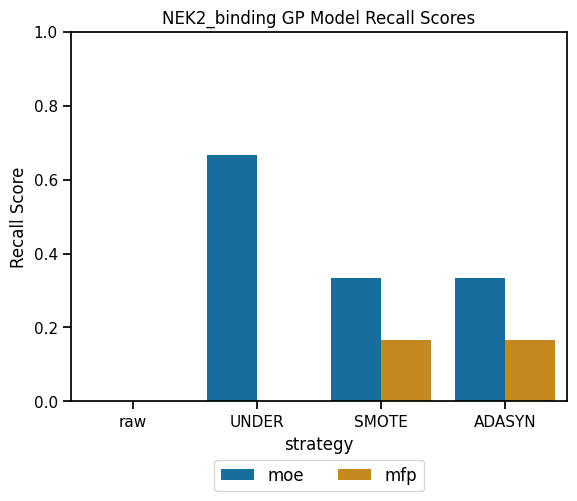

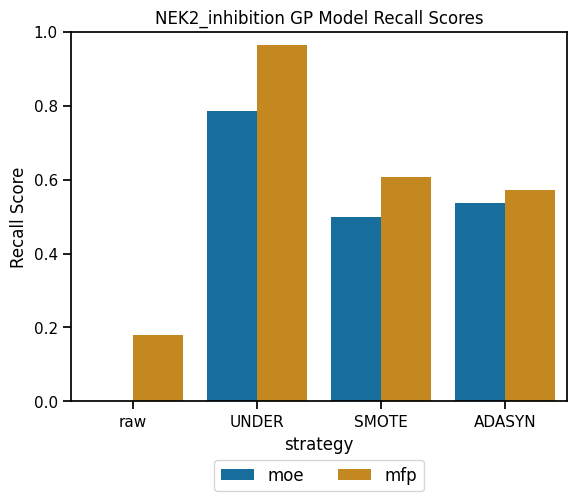

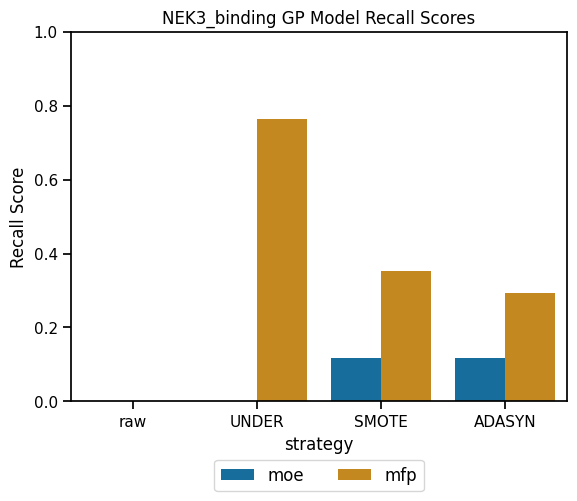

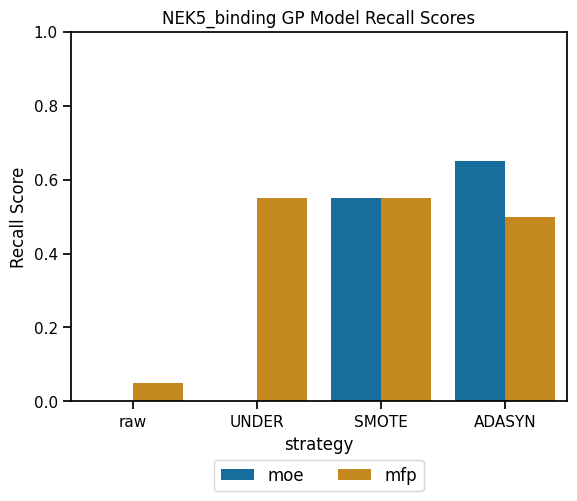

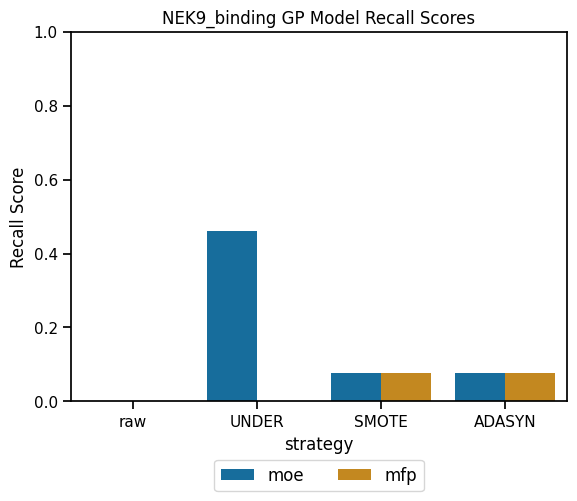

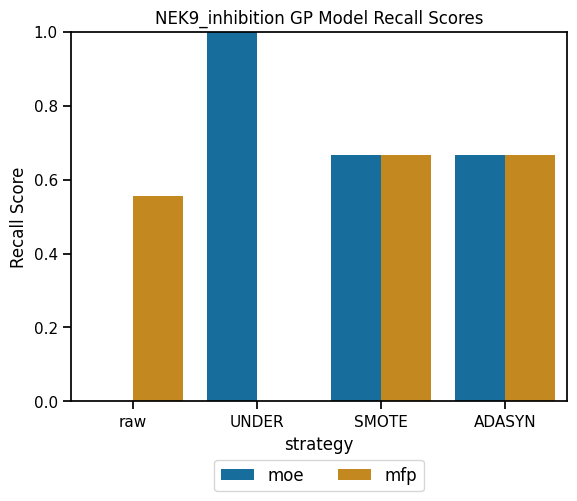

In [571]:
# neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
# # value_vars=['accuracy','precision', 'recall','specificity', 'ROC-AUC', 'MCC', 'Balanced Accuracy','f1']
# value_vars=['recall']
# for n, nek in enumerate(neks): 
#     nek_df = test_df[test_df['NEK'] ==nek]
#     print(nek) 
#     dflong=nek_df.melt(id_vars=['strategy', 'feat_type', 'model','cm'], value_vars=['recall'],
#            var_name='Metric', value_name='Metric_value')
#     dflong=dflong.sort_values('Metric')

#     sns.set_context('notebook')
#     sns.set_palette('colorblind')
#     # grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=3, s=70, jitter=0.2)
#     grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=2)
#     # kwargs={'loc':(0.79, 0.15)}
#     sns.move_legend(grid, (0.65, 0.5))
#     grid.fig.subplots_adjust(top=0.95)
#     plt.ylabel('Recall Score')

#     grid.fig.suptitle(f'GP Model Results {nek}');
#     plt.savefig(f"figures/GP_{nek}_metrics_catplot_xsamp.png")
    
#     plt.show();
    
#     print()
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
for n, nek in enumerate(neks): 
    nek_df = test_df[test_df['NEK'] ==nek]
    sns.set_context('notebook')
    sns.set_palette('colorblind')
    # grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=3, s=70, jitter=0.2)
    # grid=sns.catplot(nek_df, x='strategy', y='recall', hue='feat_type', kind='bar', col_wrap=2)
    grid = sns.barplot(nek_df, x='strategy', y='recall', hue='feat_type')
    # kwargs={'loc':(0.79, 0.15)}
    # sns.move_legend(grid, (1, 0.5))
    # grid.fig.subplots_adjust(to
    # grid.get_legend().remove()
    grid.set(ylim=(0,1))
    grid.legend(loc='center', bbox_to_anchor=(0.5,-.2), ncol=2,fontsize=12)
    plt.ylabel('Recall Score')
    plt.title(f'{nek} GP Model Recall Scores')
    # grid.suptitle(f'GP Model Results {nek}');
    plt.savefig(f"figures/GP_plots/GP_{nek}_recall_bystrat.png",bbox_inches='tight')
    plt.show();
    
    print()


# Display metrics with feat type on x 

In [572]:
raws = sns.color_palette('Grays', 1) 
smotes = sns.color_palette('Greens', 1)
unders = sns.color_palette('Reds',1) # Purples, RdPu, Reds, YlGn, YlGnBu, YlOrBr, YlOrRd, BuPu, BuGn , dark:salmon_r
adasyns = sns.color_palette('Purples',1)
sampling_palette = raws+smotes+unders+adasyns
moes = sns.color_palette('Blues', 4) 
mfps = sns.color_palette('YlOrBr', 4)
dataset_palette = moes+mfps

NEK2_binding


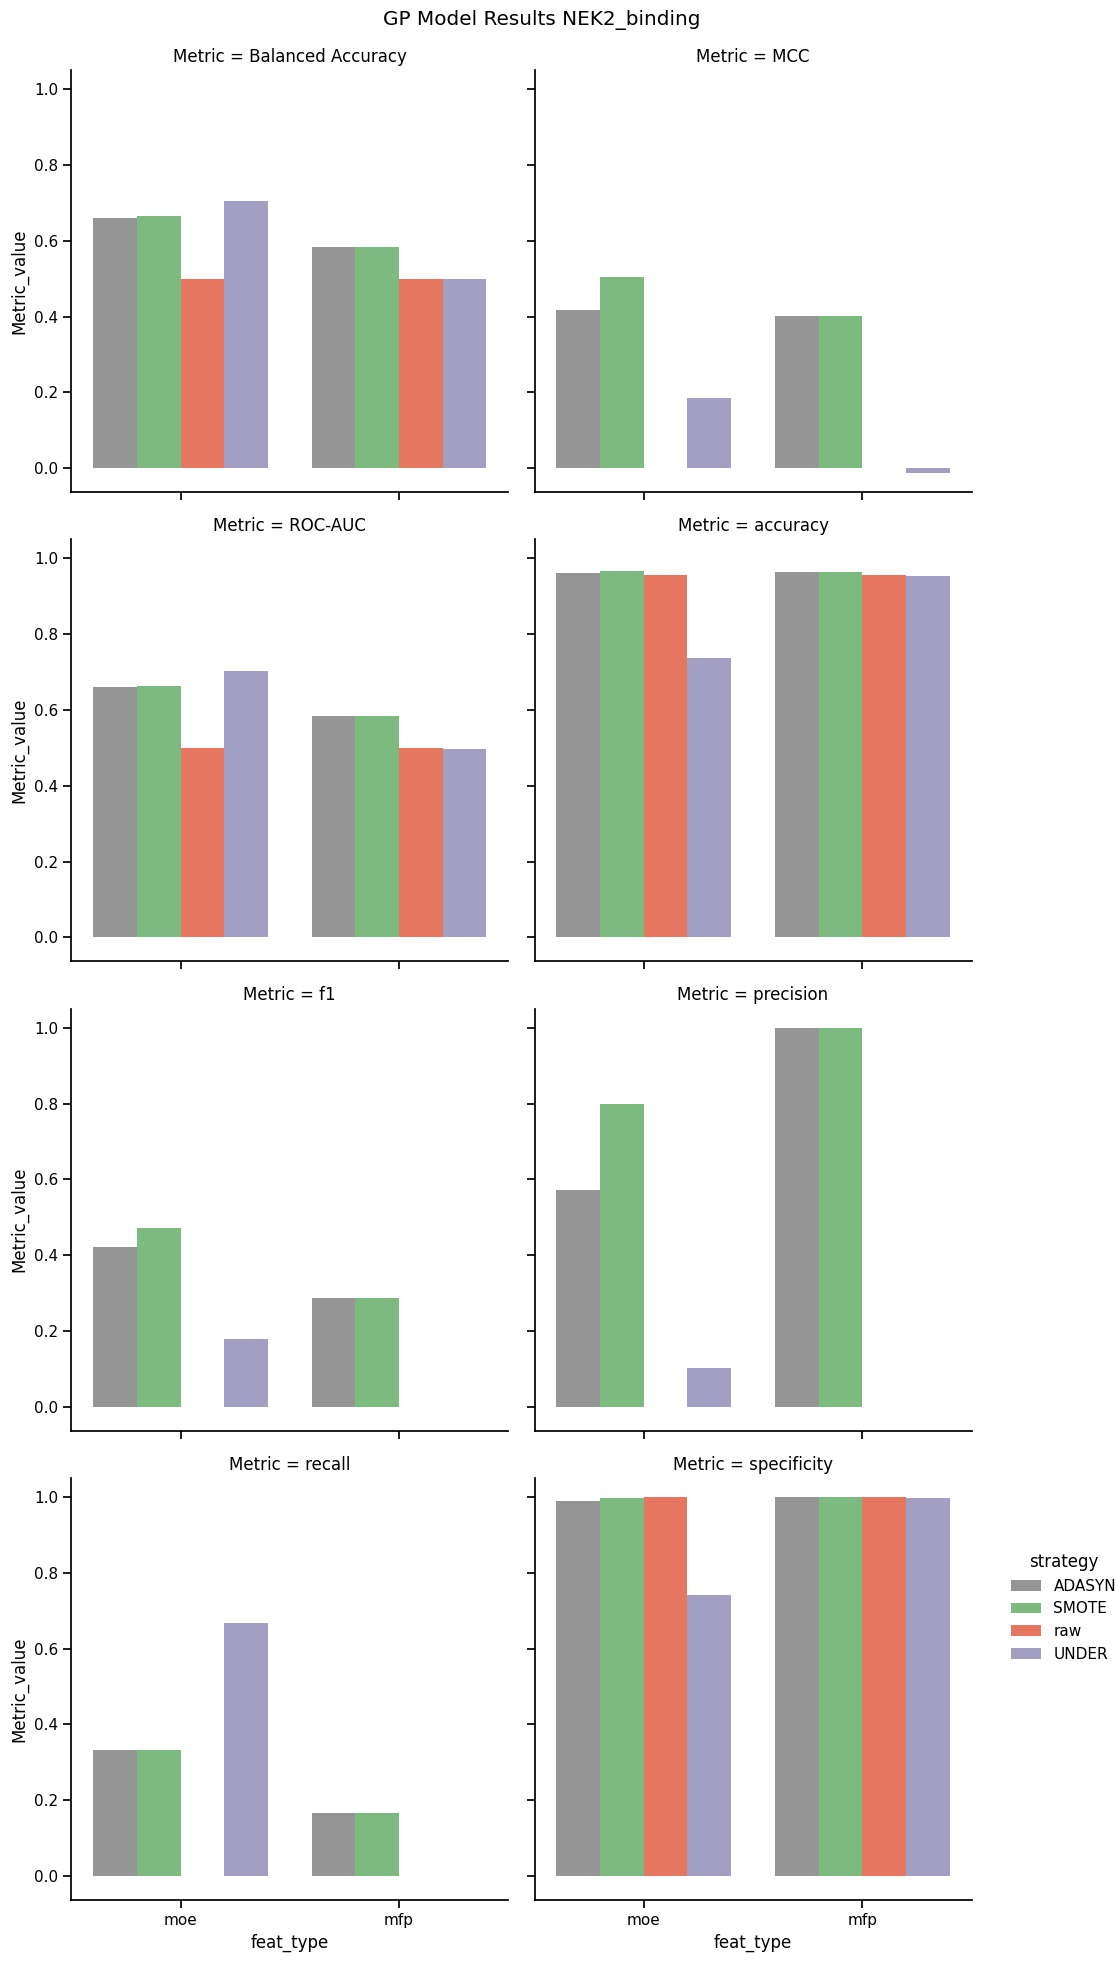


NEK2_inhibition


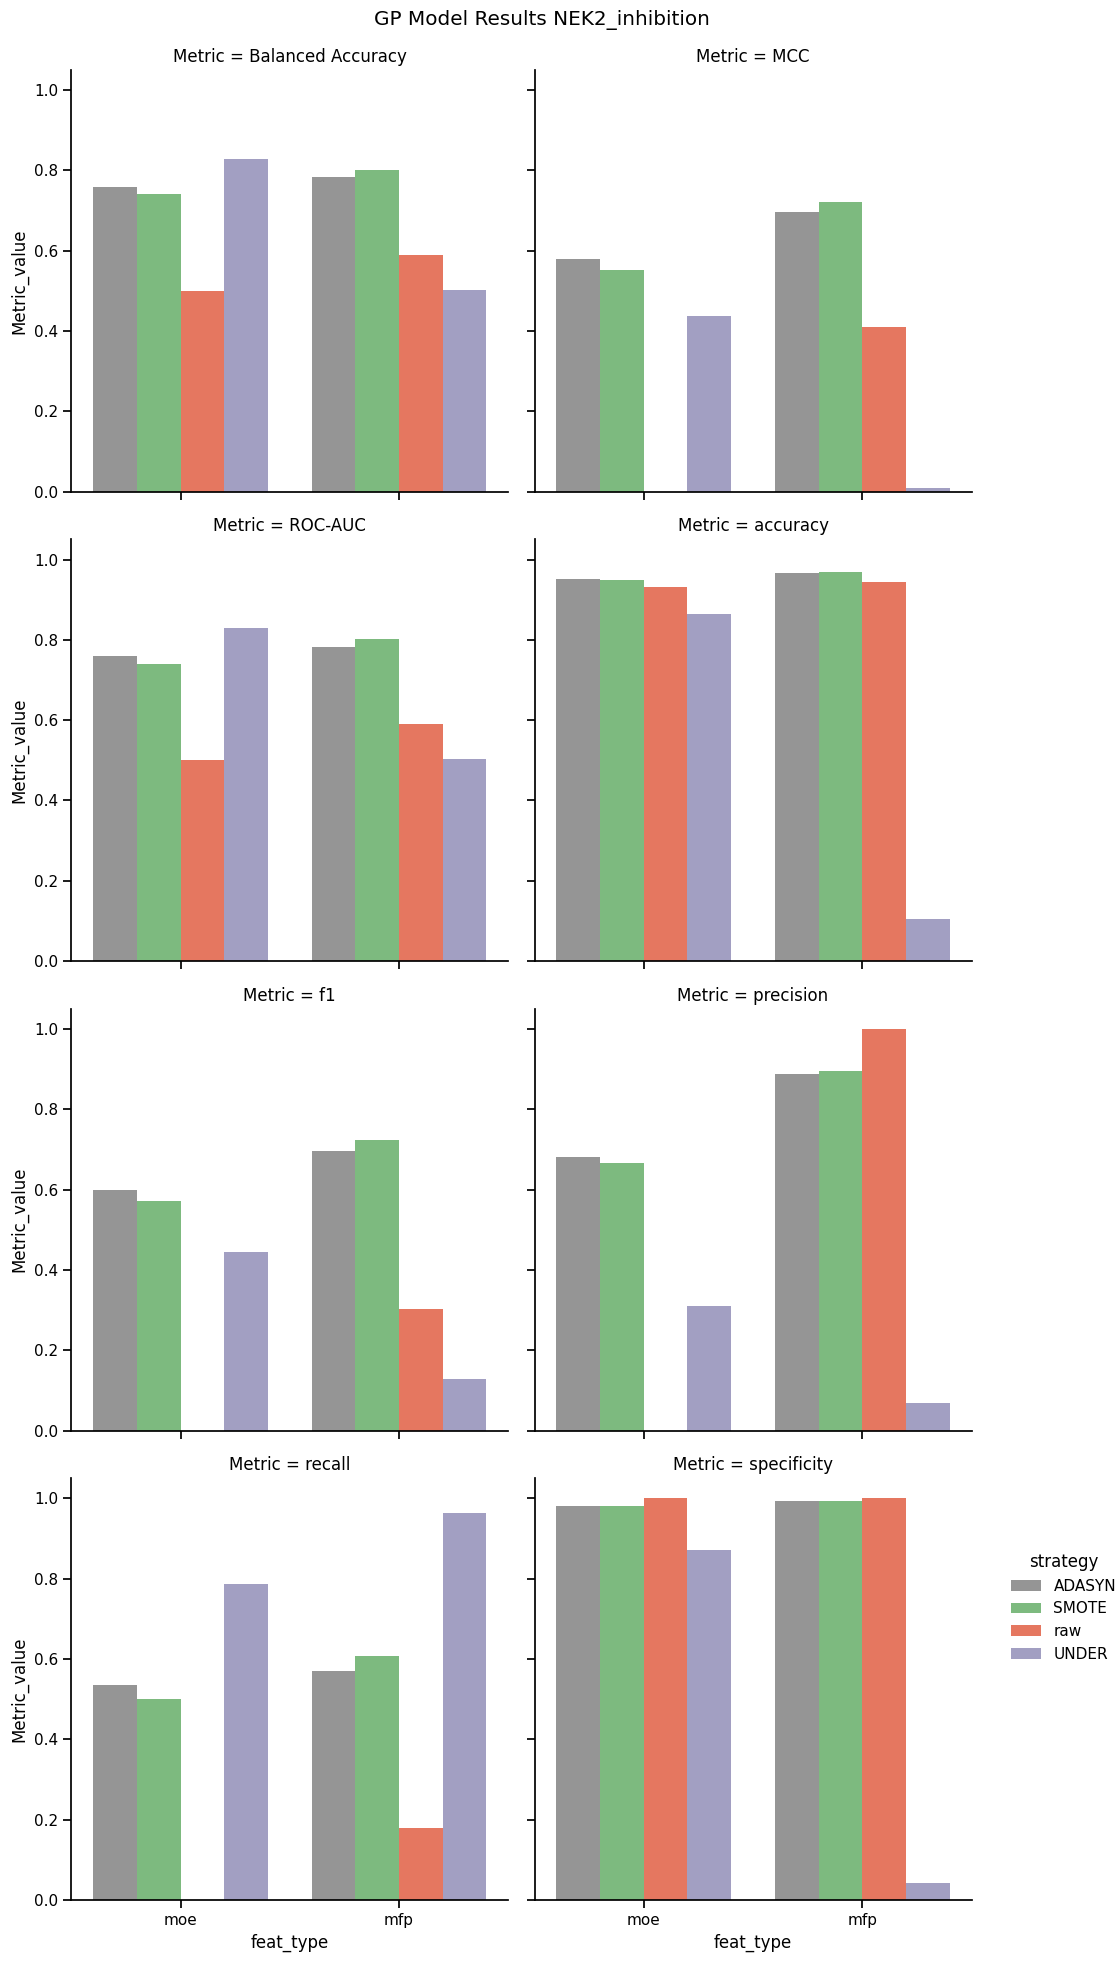


NEK3_binding


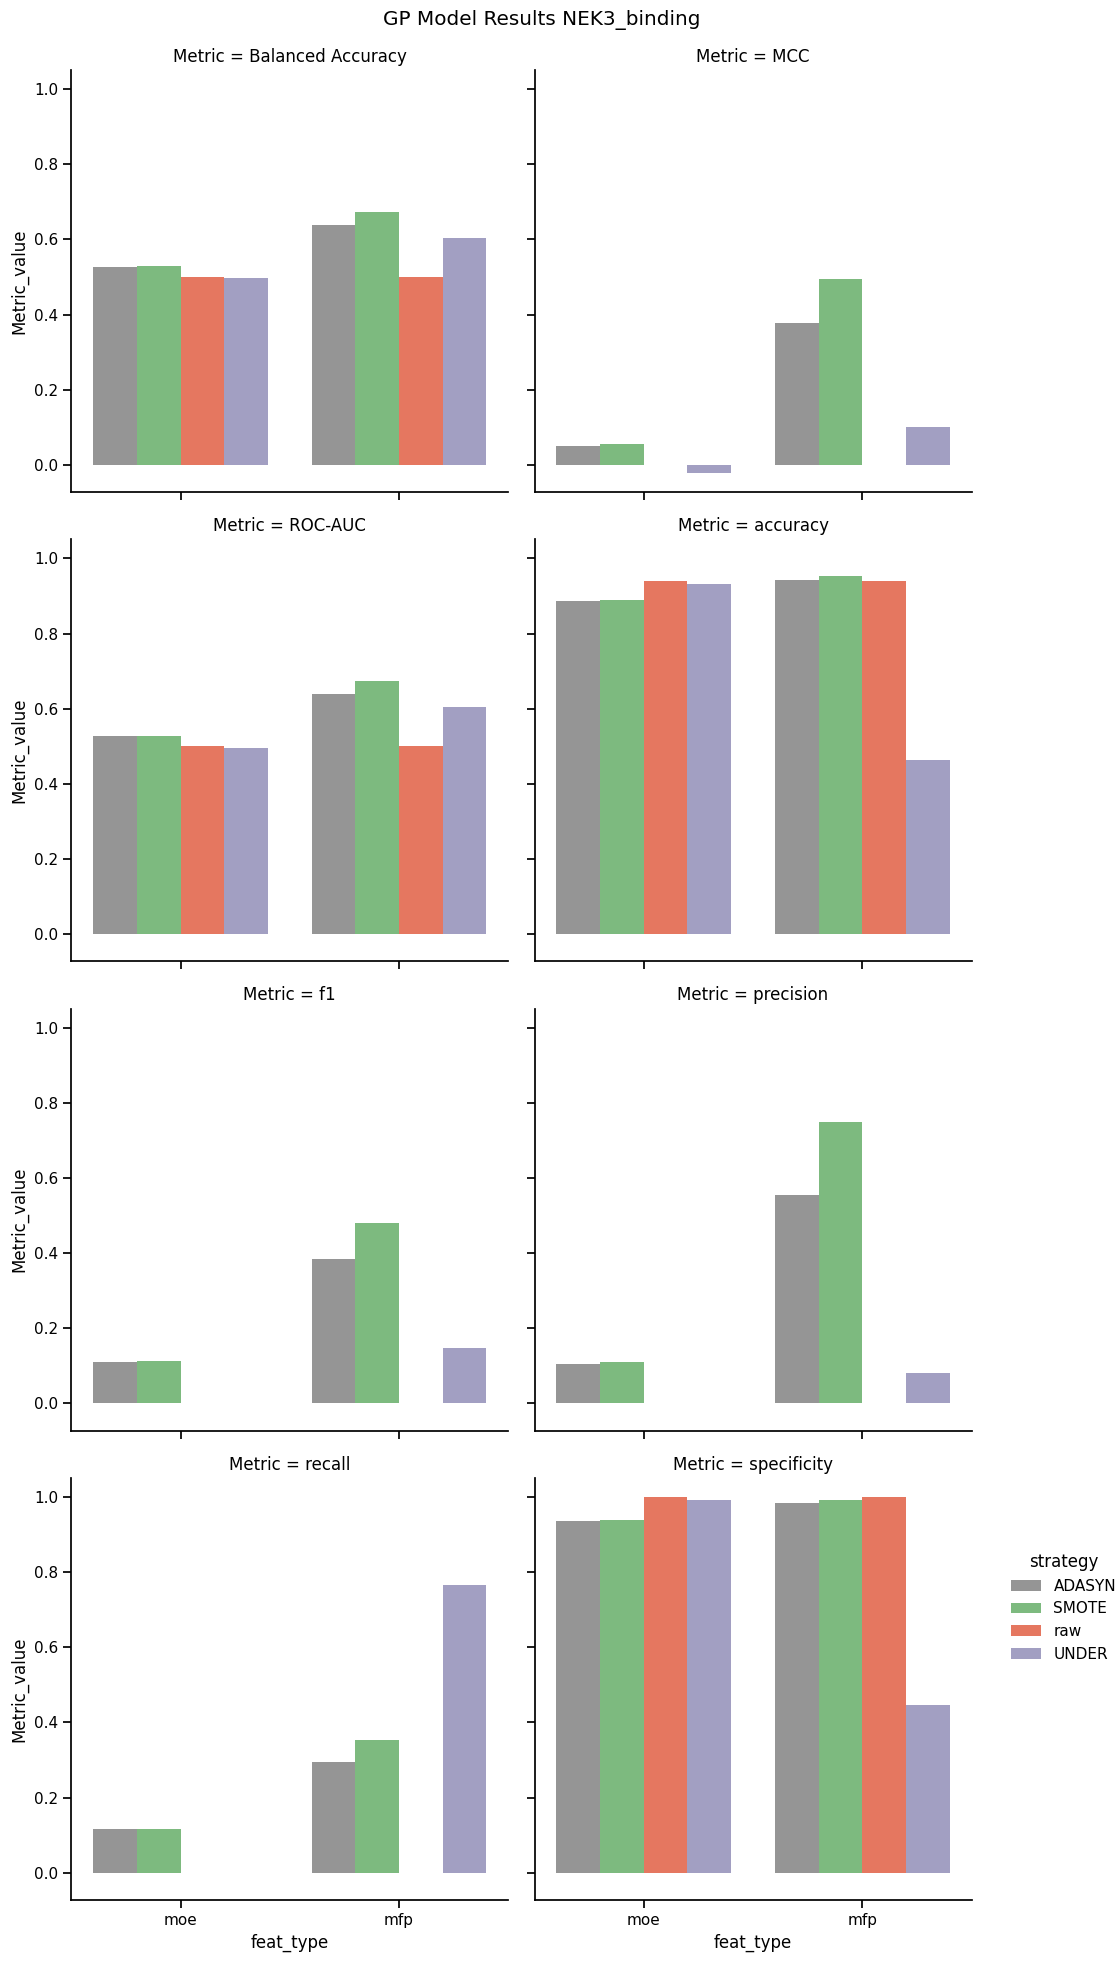


NEK5_binding


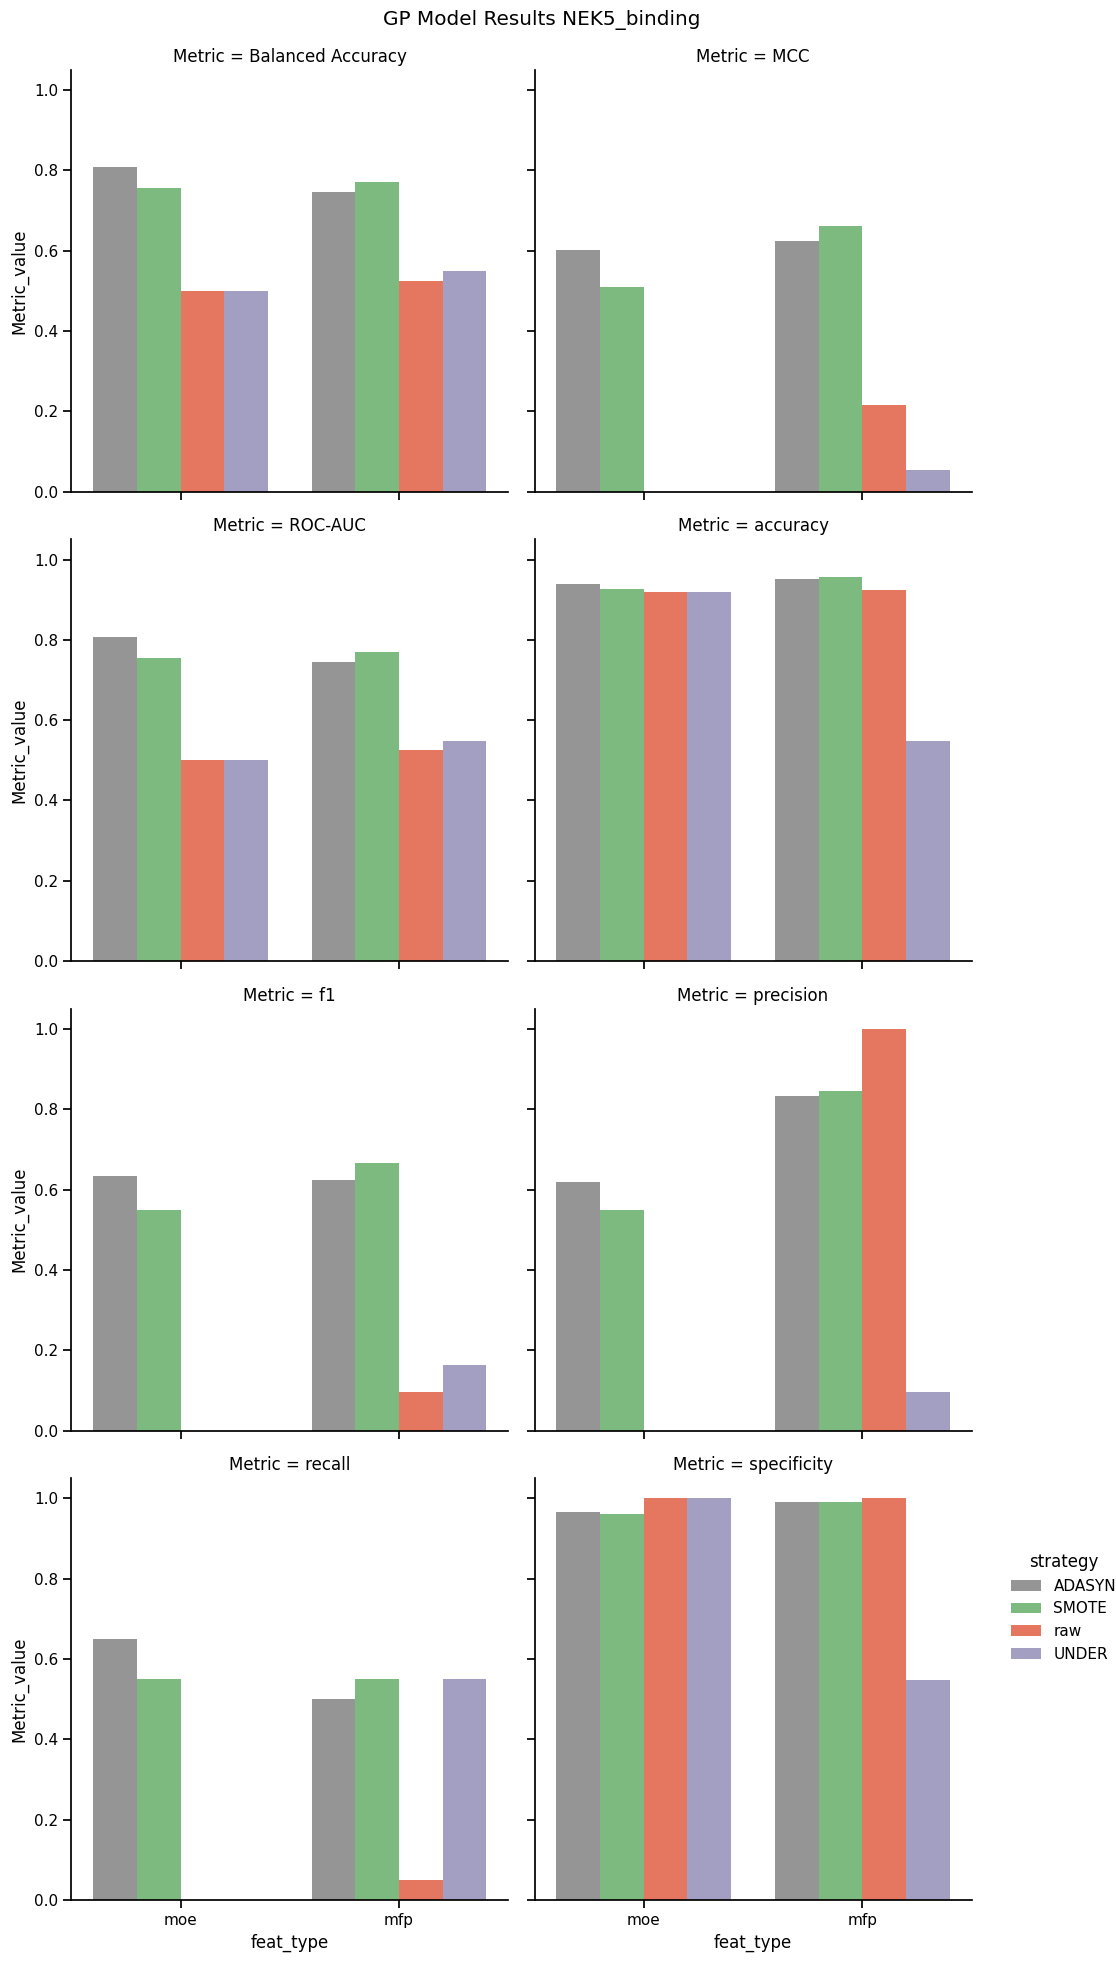


NEK9_binding


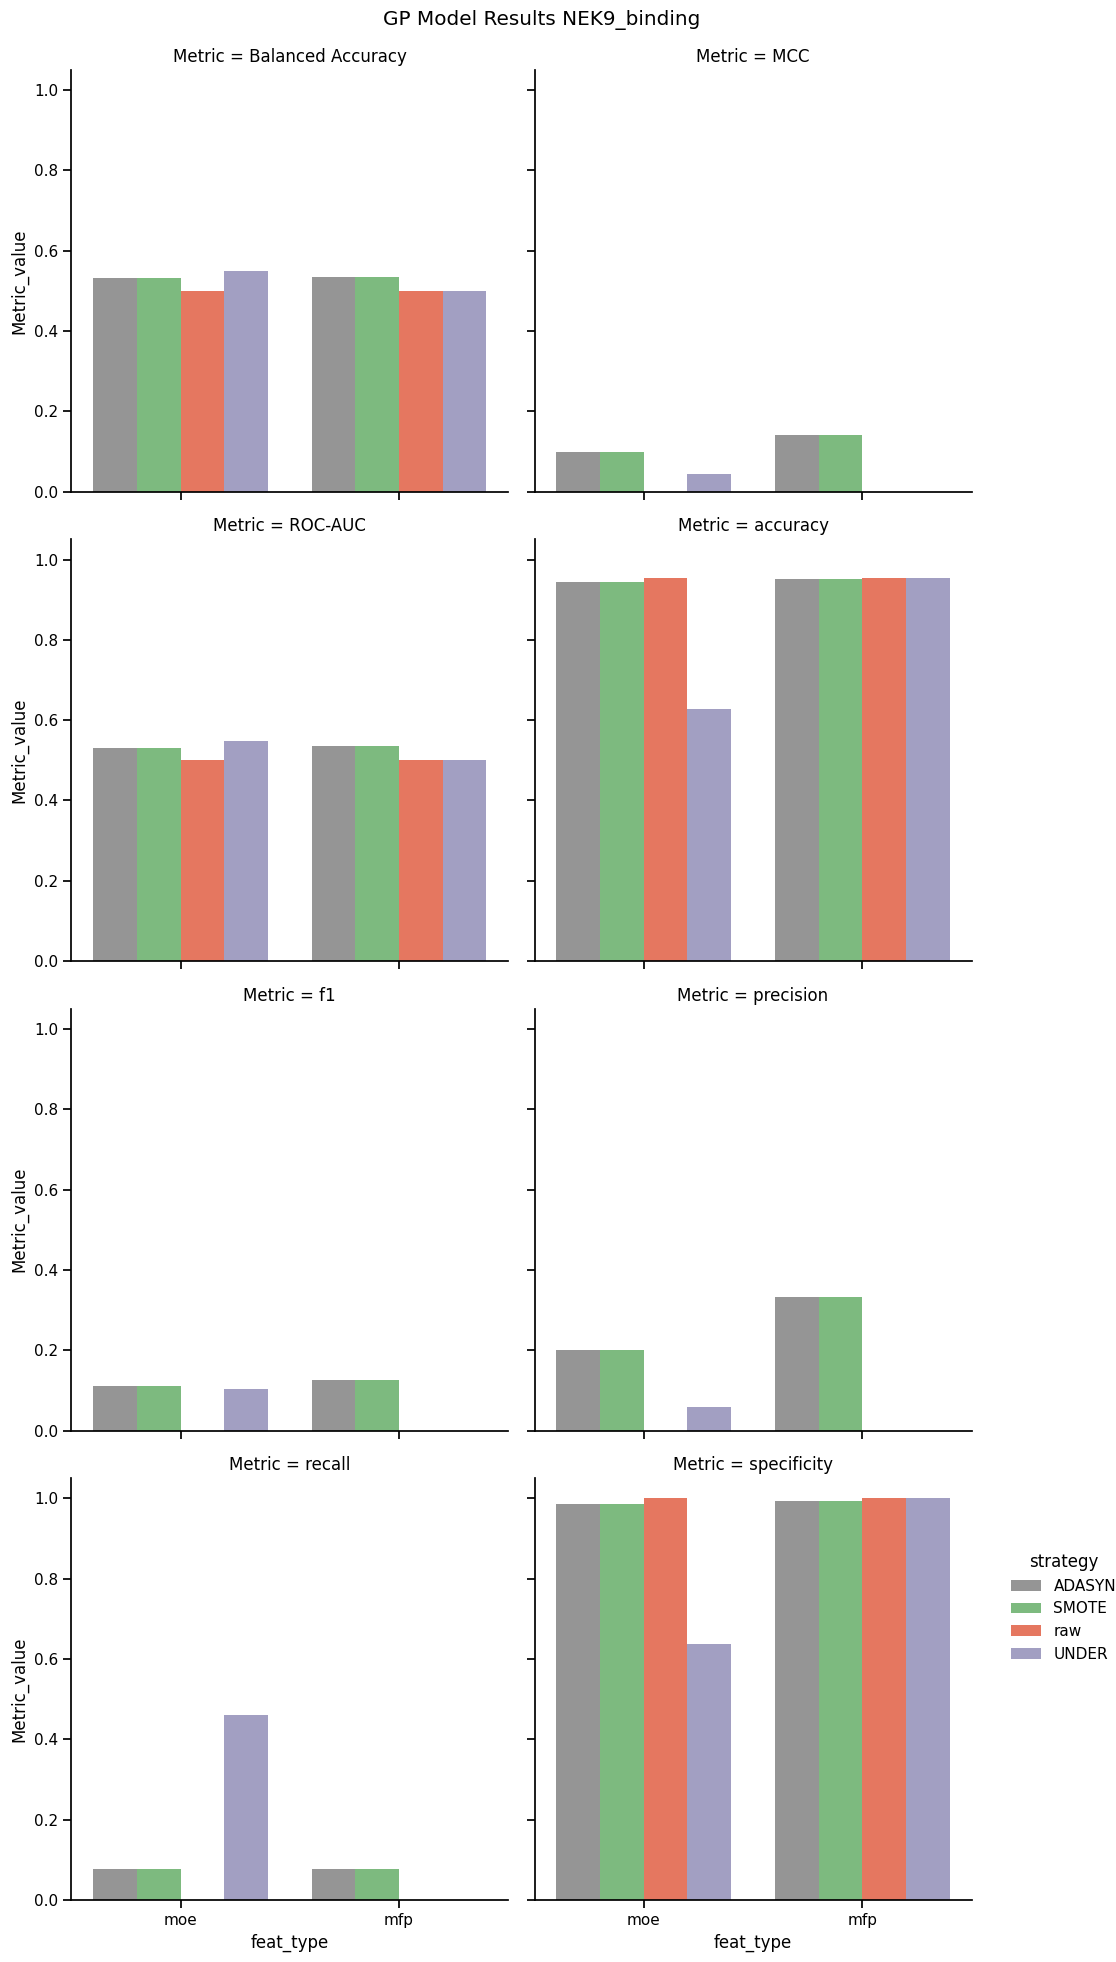


NEK9_inhibition


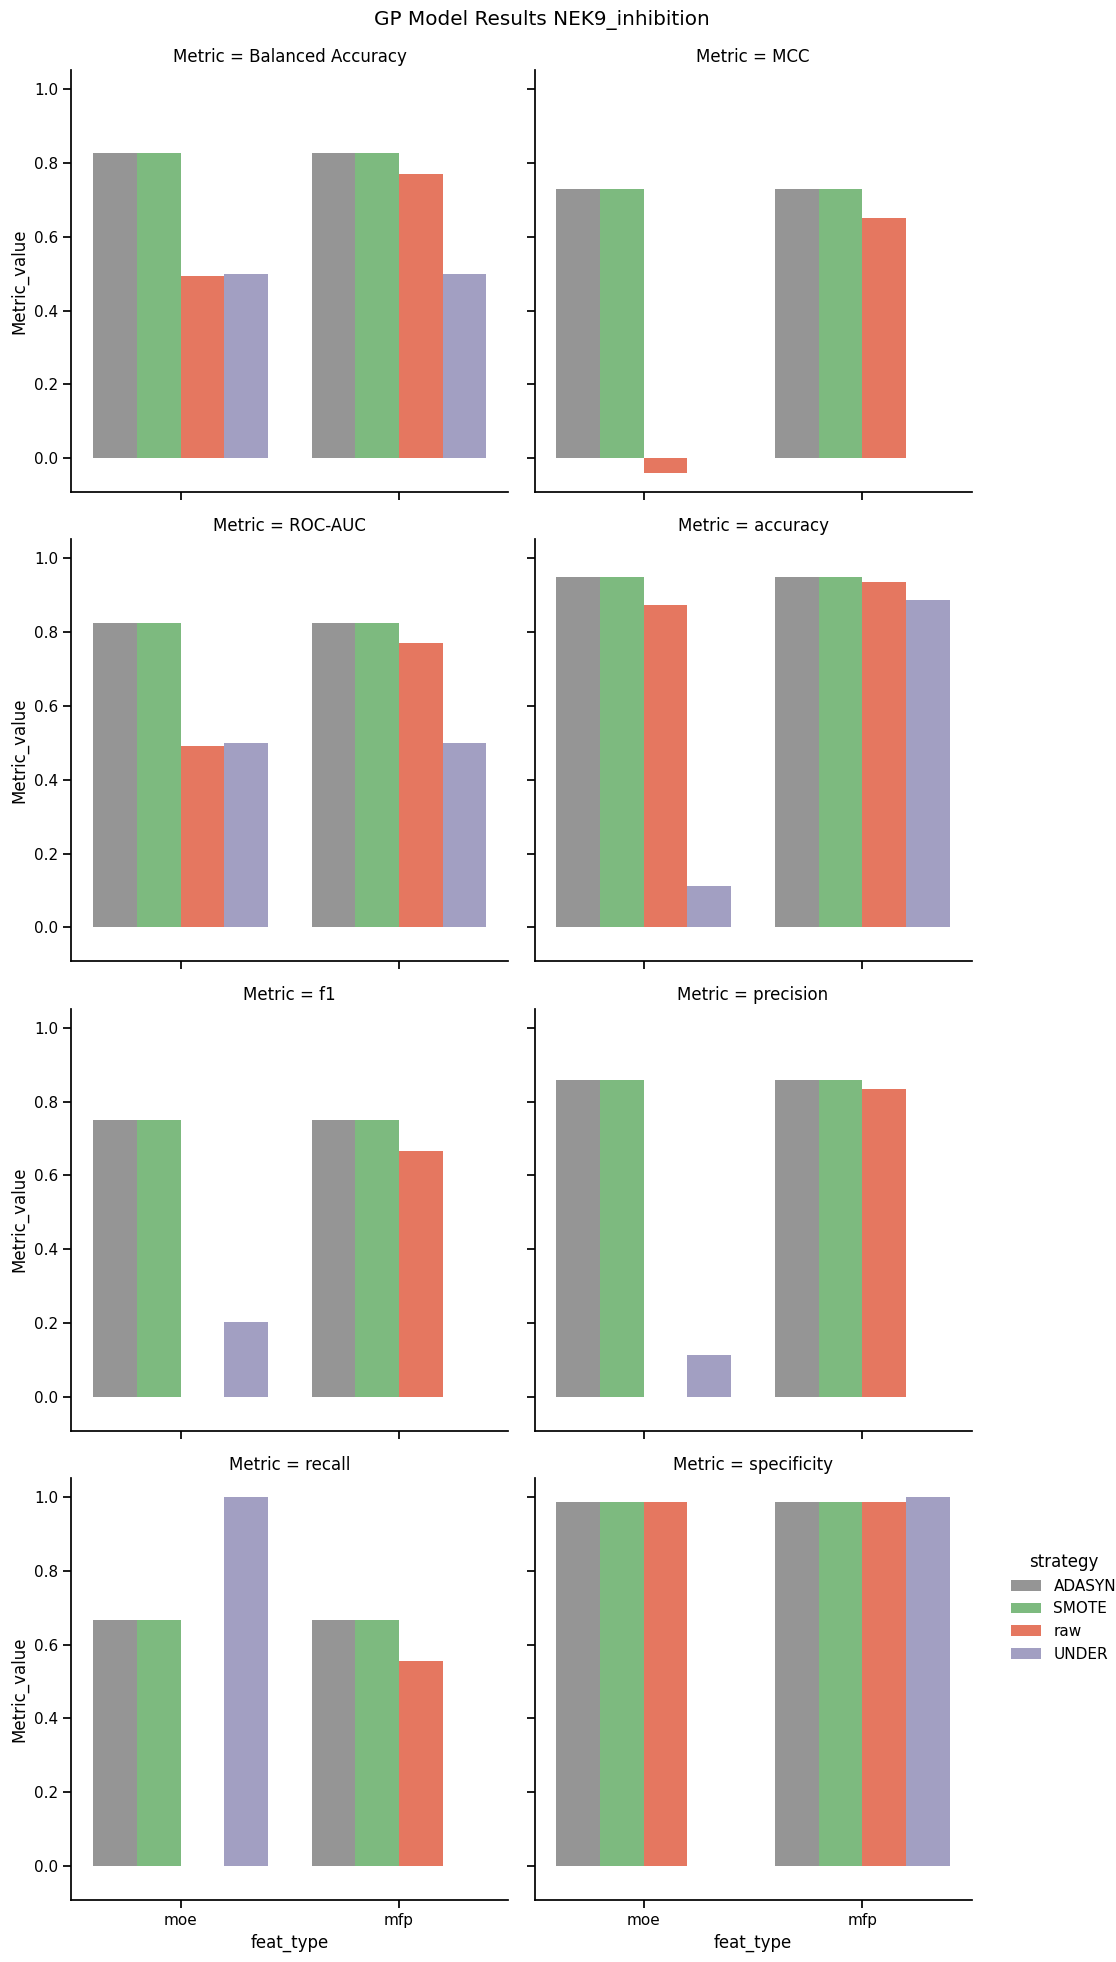

In [573]:
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
for n, nek in enumerate(neks): 
    nek_df = test_df[test_df['NEK'] ==nek]
    print(nek)
    dflong=nek_df.melt(id_vars=['strategy', 'feat_type','model','cm'], value_vars=['accuracy','precision', 'recall','specificity', 'ROC-AUC', 'MCC', 'Balanced Accuracy','f1'],
           var_name='Metric', value_name='Metric_value')
    dflong=dflong.sort_values('Metric')
    sns.set_context('notebook')
    sns.set_palette('colorblind')
    # grid=sns.catplot(dflong, x='feat_type', y='Metric_value', hue='strategy', col='Metric', col_wrap=3, s=70, jitter=0.2)
    grid=sns.catplot(dflong, x='feat_type', y='Metric_value', hue='strategy', col='Metric',  kind='bar', col_wrap=2,palette=sampling_palette)
    sns.move_legend(grid, (.9, 0.15))
    grid.fig.subplots_adjust(top=0.95)
    
    grid.fig.suptitle(f'GP Model Results {nek}');
    plt.savefig(f"figures/GP_plots/GP_{nek}_metrics_catplot_xfeat.png")
    plt.show();
    print()
    

NEK2_binding


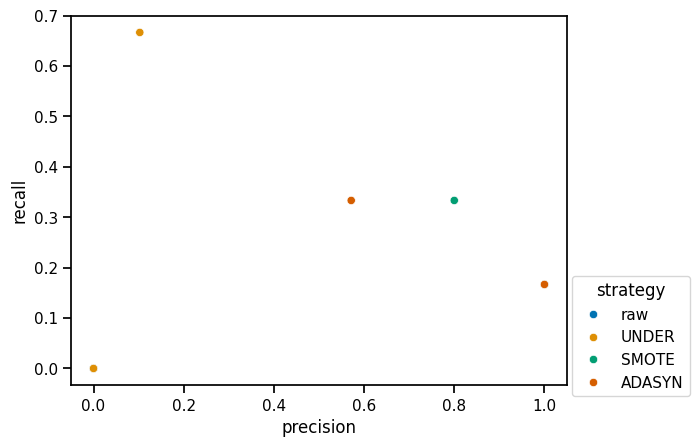


NEK2_inhibition


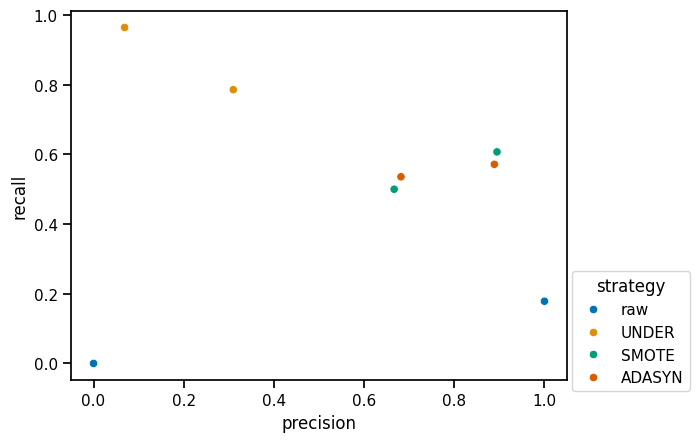


NEK3_binding


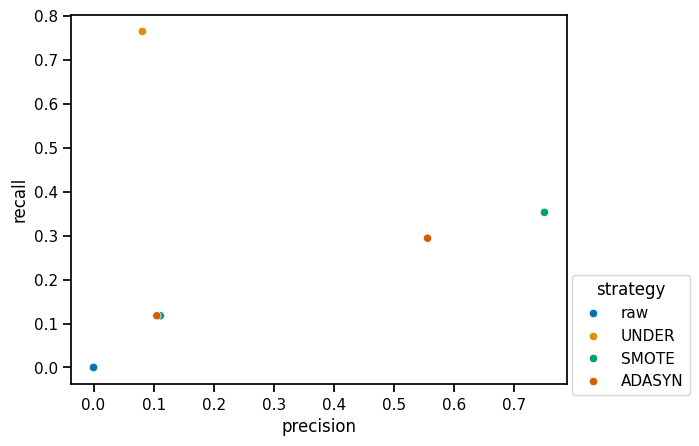


NEK5_binding


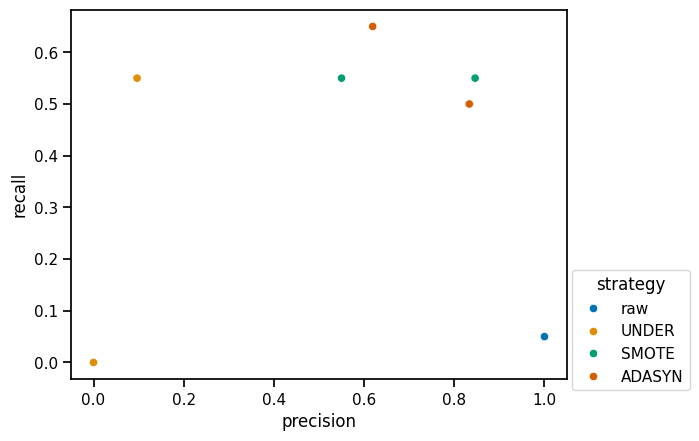


NEK9_binding


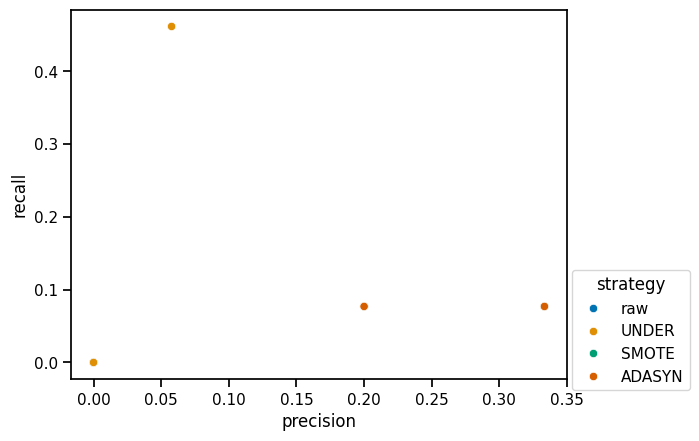


NEK9_inhibition


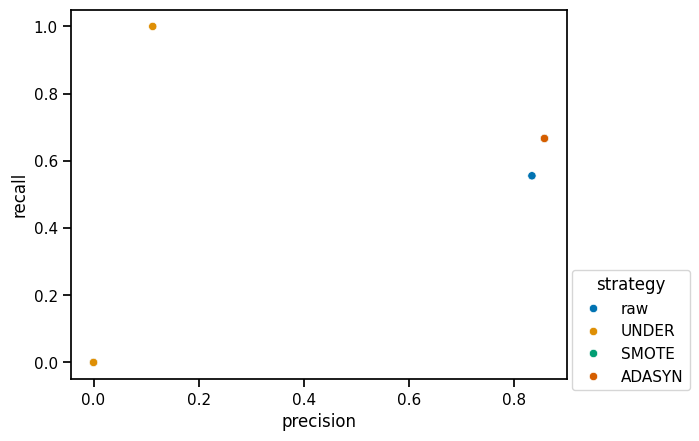

In [574]:
# g=sns.scatterplot(test_df[['strategy', 'precision', 'recall']], x='precision', y='recall', hue='strategy')
# sns.move_legend(g, (1.01, -0.03))
for n, nek in enumerate(neks): 
    nek_df = test_df[test_df['NEK'] ==nek]
    print(nek)
    g=sns.scatterplot(nek_df[['strategy', 'precision', 'recall']], x='precision', y='recall', hue='strategy')
    sns.move_legend(g, (1.01, -0.03))
        
    grid.fig.suptitle(f'GP Model Results {nek}');
    plt.show();
    print()
    

# Plot all metrics together 

In [575]:
testing2 = test_df
# type(testing2[metric_cols])
testing2.columns
metric_palette2 = sns.color_palette('RdPu',n_colors=8)
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
size_cols = ['num_samples_train','actives_train', 'active%_train', 'num_samples_test', 'actives_test',
       'active%_test', 'total_size', 'total_actives', 'total actives/total%','train actives/total%']

<Figure size 1200x1000 with 0 Axes>

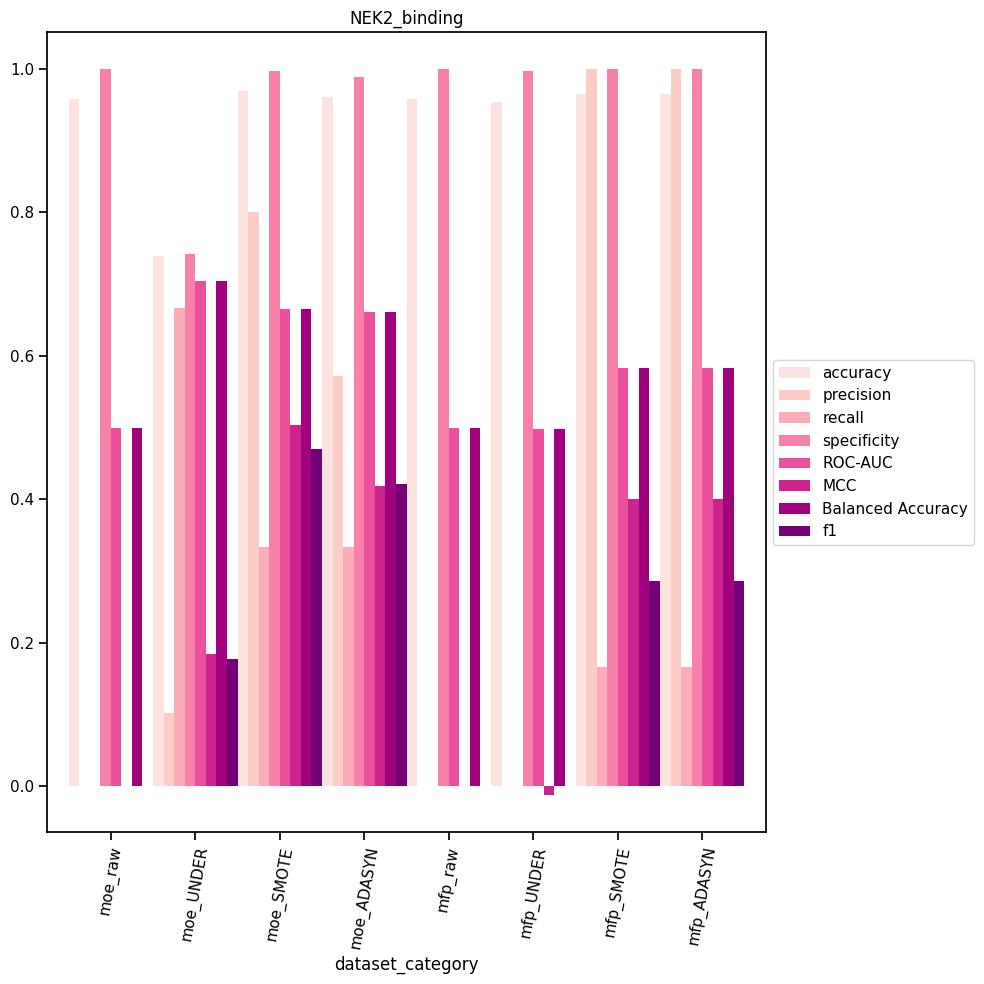

<Figure size 1200x1000 with 0 Axes>

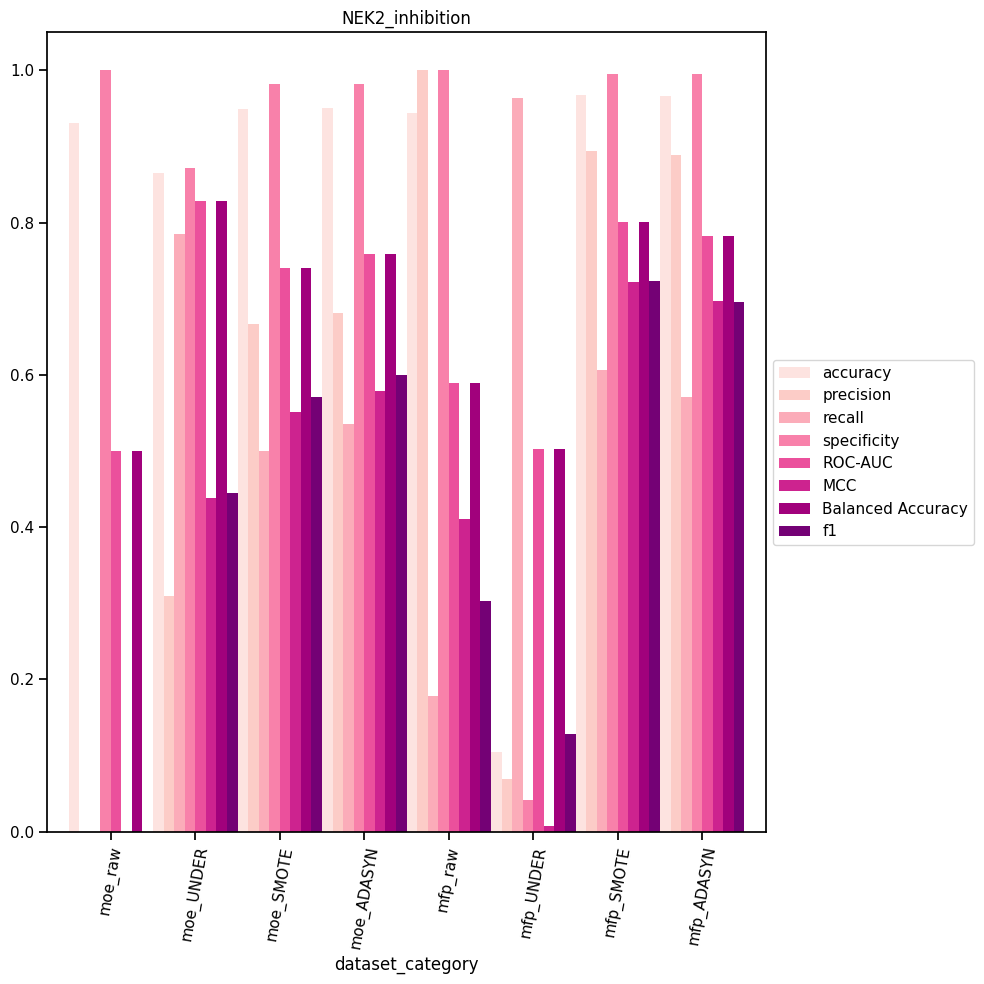

<Figure size 1200x1000 with 0 Axes>

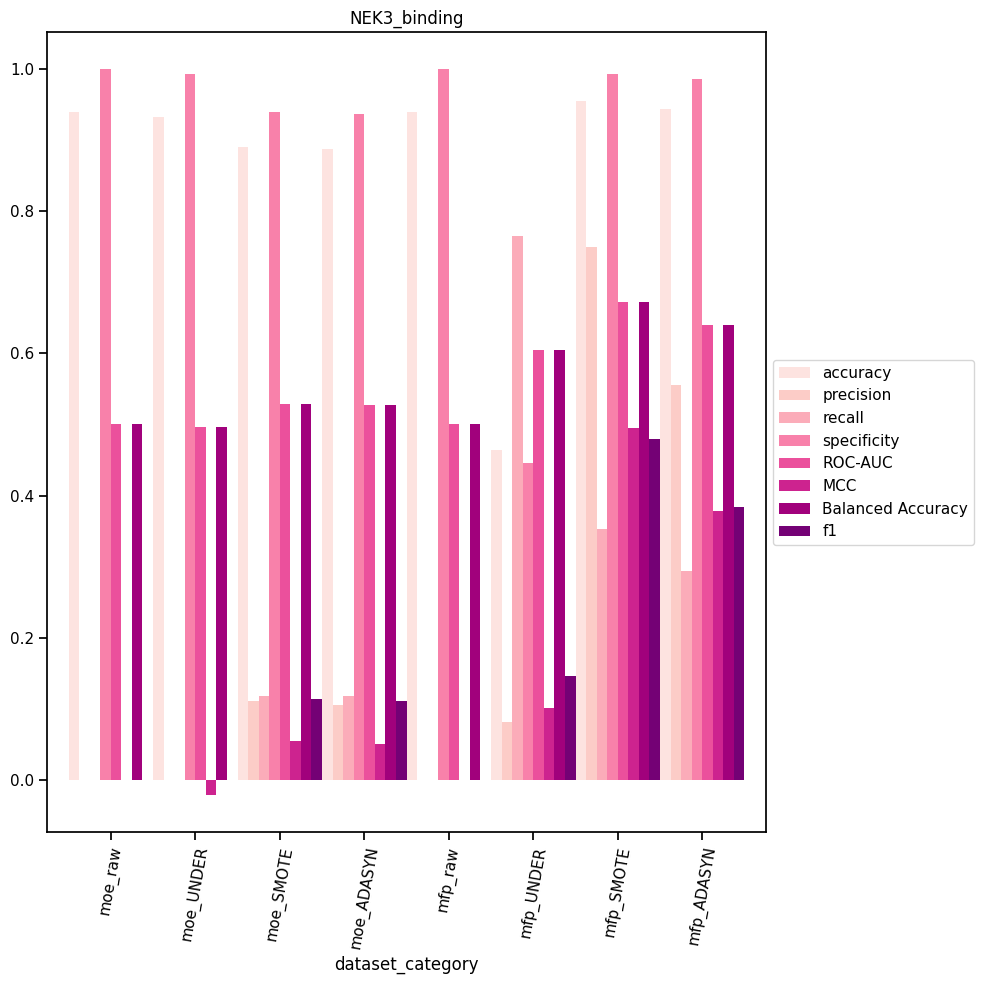

<Figure size 1200x1000 with 0 Axes>

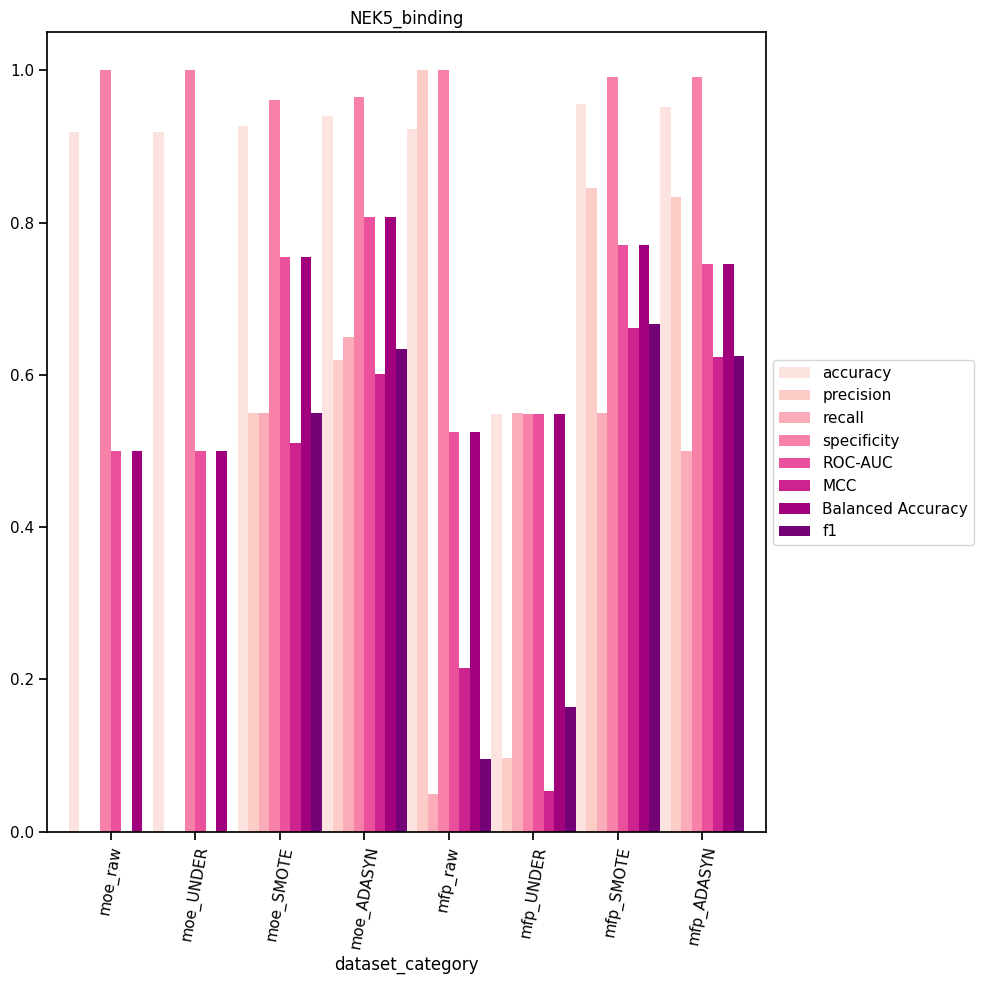

<Figure size 1200x1000 with 0 Axes>

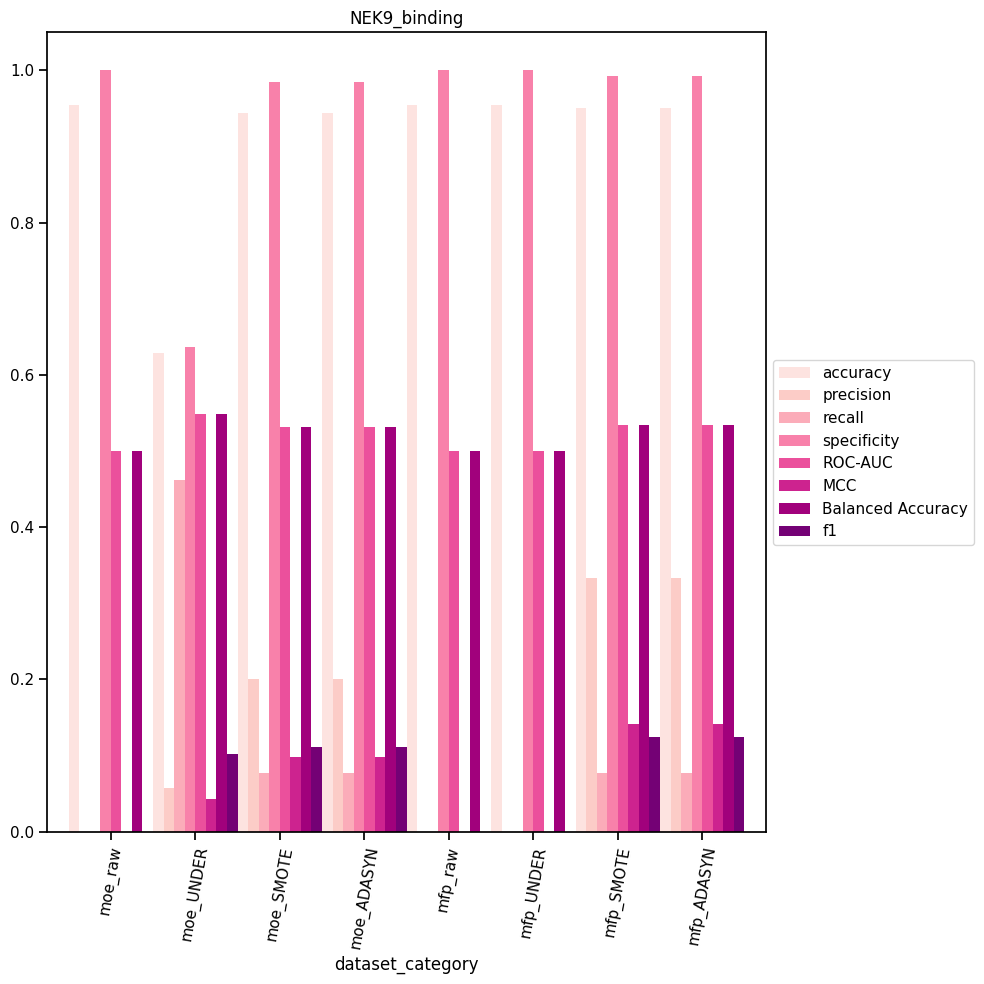

<Figure size 1200x1000 with 0 Axes>

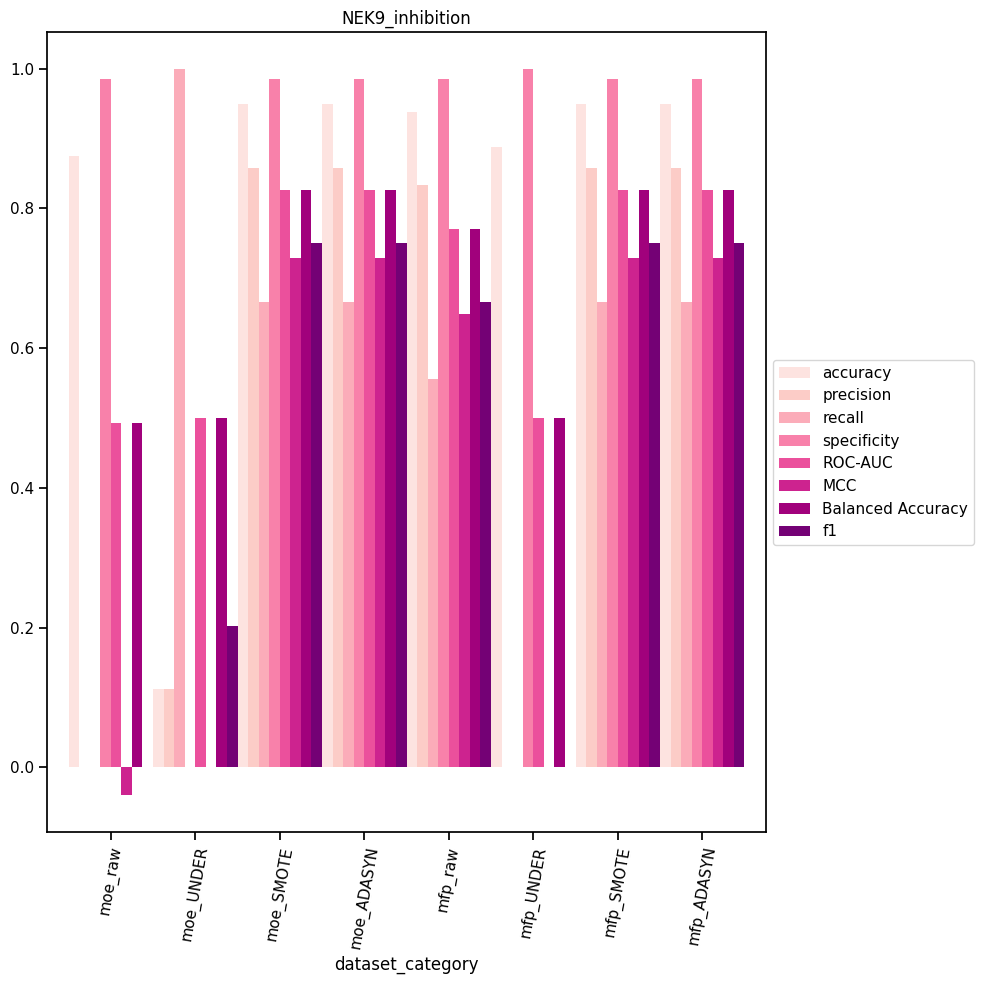

In [580]:
for n, nek in enumerate(neks): 
    df = test_df[test_df['NEK'] == nek]
    df = df[metric_cols]
    # df['model'] = df['feat_type'].astype(str)+'_'+df['strategy']
    # df.sort_values('feat_type') 
    plt.figure(figsize=(12, 10))
    ax = df.plot(x='dataset_category',kind='bar', figsize=(10,10),width=1,color=metric_palette2)
    
    # plt.ylabel('Recall Score')
    plt.title(f'{nek}')
    plt.xticks(rotation=80)  
    ax.legend(loc='upper left', bbox_to_anchor=(1,.6))
    # ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(f'figures/GP_plots/{nek}_GP_all_metrics.png')
    plt.show();
    

# Plotting above in subplots

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2406088662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=size_cols,inplace=True)
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2406088662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=size_cols,inplace=True)
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2406088662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

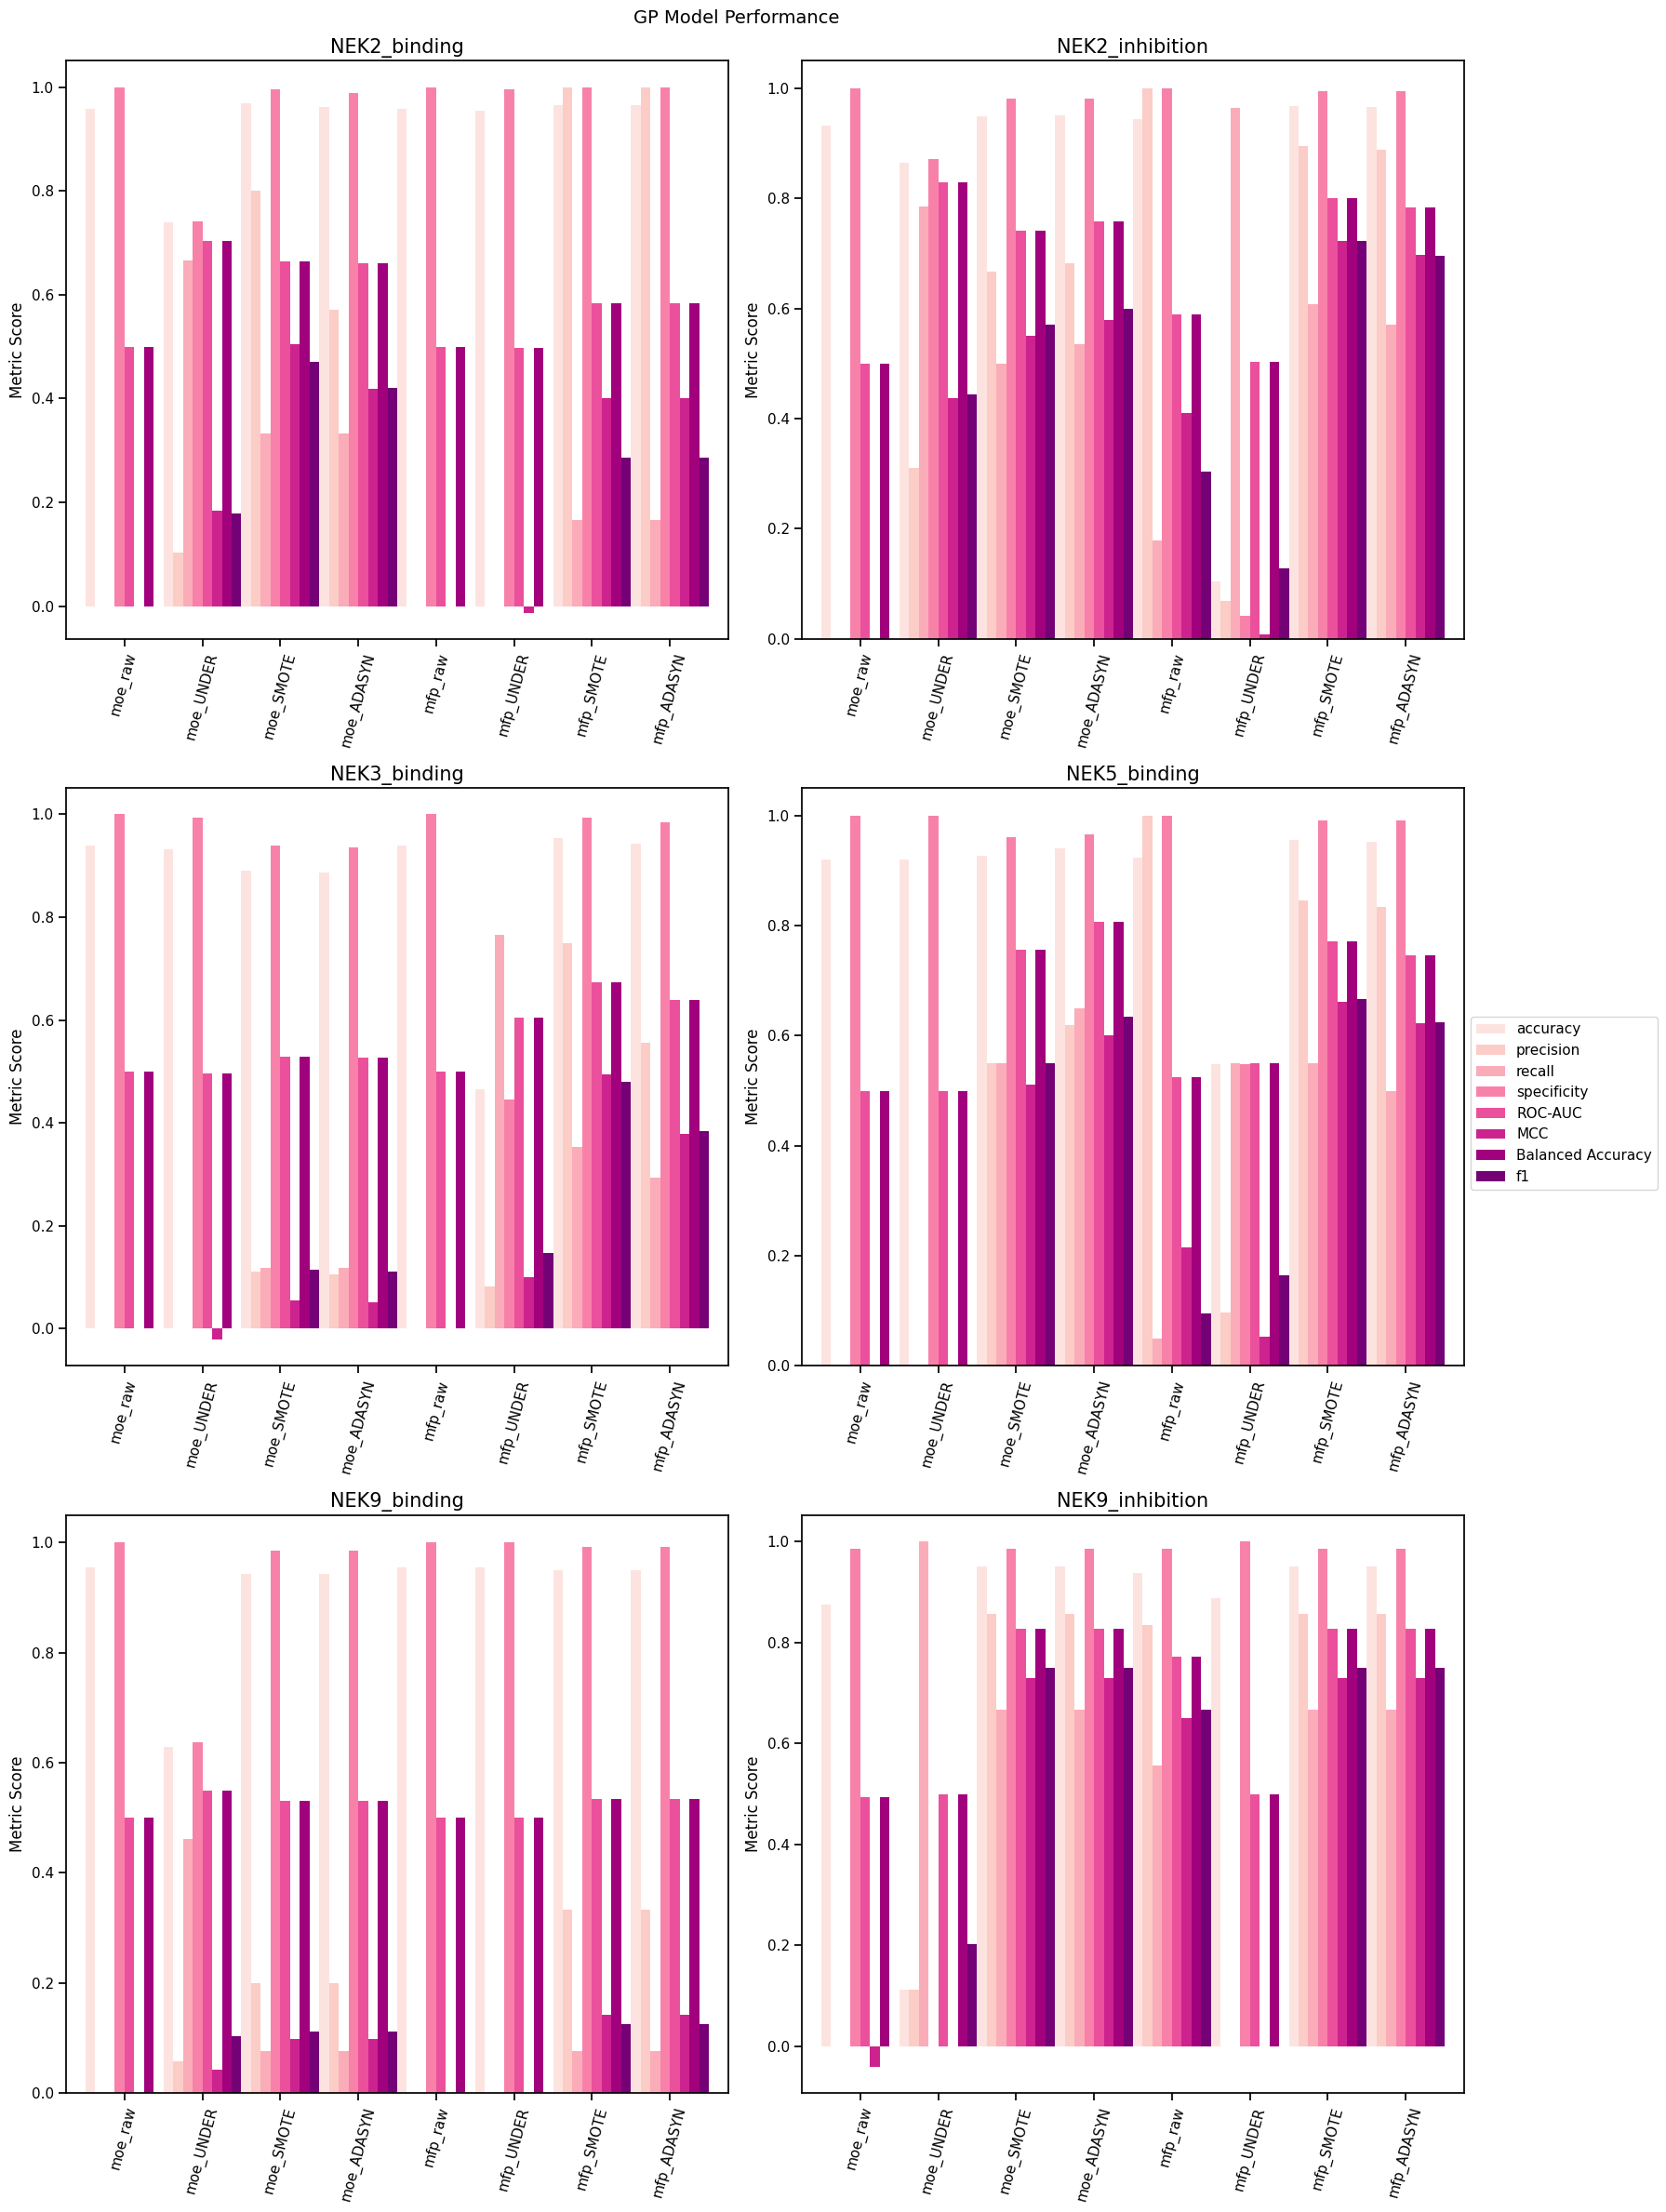

In [582]:
nek_dfs = [test_df[test_df['NEK'] == nek] for nek in neks]
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(3, 2, figsize=(16,24))
axes = axes.flatten()
for i, df in enumerate(nek_dfs):
    ax = axes[i]
    
    df.drop(columns=size_cols,inplace=True)
    df=df[metric_cols]
    df.plot(x='dataset_category', kind='bar', ax=ax,legend=False,color=metric_palette2,width=1)
    # ax.set_xlabel('Model')
    ax.set_ylabel('Metric Score')
    ax.set_title(f'{neks[i]}',fontsize=15)
    ax.set_xticklabels(df['dataset_category'], rotation=75) 
    ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.056,.5))
# fig.legend(loc='upper left',)
fig.subplots_adjust(top=0.5)
fig.suptitle('GP Model Performance',y=.99,fontsize=14)
plt.tight_layout()
plt.savefig(f'figures/GP_plots/all_GP_model_metrics.png',bbox_inches='tight')
plt.show();


# Selecting best strategy/feat for metrics 

In [584]:
def select_winner(df, compare_type): 
    metrics = ['accuracy',	'precision',	'recall',	'specificity',	'ROC-AUC',	'MCC',	'Balanced Accuracy' ,'f1'] 
    df_result = pd.DataFrame(columns=metrics)
    results=[]
    for compare in df[compare_type].unique():
        compare_df = df[df[compare_type] == compare]
        
        best_feat_types = {'compare': compare}

        for met in metrics:
            best_feat_type = compare_df.loc[compare_df[met].idxmax()]
            best_feat_types[met] = best_feat_type[met]
            best_feat_types['feat_type'] = best_feat_type['feat_type']
            best_feat_types['model'] = best_feat_type['model']
            best_feat_types['strategy'] = best_feat_type['strategy']
            best_feat_types['NEK'] = best_feat_type['NEK']

        results.append(best_feat_types)

    final_results = pd.DataFrame(results)
    return final_results
    

In [585]:
testdf = nek_df = test_df[test_df['NEK'] =='NEK2_binding']
ranked_nek2 = select_winner(testdf, 'strategy')
ranked_nek2

,compare,accuracy,feat_type,model,strategy,NEK,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1
0,raw,0.957597,moe,NEK2_binding_moe_raw_GP,raw,NEK2_binding,0.000000,0.000000,1.00000,0.500000,0.000000,0.500000,0.000000
1,UNDER,0.954064,moe,NEK2_binding_moe_UNDER_GP,UNDER,NEK2_binding,0.102564,0.666667,0.99631,0.704182,0.184161,0.704182,0.177778
2,SMOTE,0.968198,moe,NEK2_binding_moe_SMOTE_GP,SMOTE,NEK2_binding,1.000000,0.333333,1.00000,0.664822,0.504211,0.664822,0.470588
3,ADASYN,0.964664,moe,NEK2_binding_moe_ADASYN_GP,ADASYN,NEK2_binding,1.000000,0.333333,1.00000,0.661132,0.418102,0.661132,0.421053


# For each metric print moe or mfp if that metric had a better score 

In [588]:
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
for n, nek in enumerate(neks): 
    nek_df = test_df[test_df['NEK'] ==nek]
    # print(nek)
    metrics = ['accuracy',	'precision',	'recall',	'specificity',	'ROC-AUC',	'MCC',	'Balanced Accuracy' ,'f1'] 
    df_result = pd.DataFrame(columns=metrics)
    results=[]
    # for met in metrics:

    #     metric_acc = nek_df.groupby('feat_type')[met].max().idxmax()
    #     df_result.loc[0, met] = metric_acc
        
    # df_result['NEK'] = nek
    # results.append(df_result)
    results = []
    
    for nek in neks:
        nek_df = test_df[test_df['NEK'] == nek]
        
        
        for strategy in nek_df['strategy'].unique():
            strat_df = nek_df[nek_df['strategy'] == strategy]
            model = nek_df['model'] 
            # display(strat_df)
            best_feat_types = {}
    
            for met in metrics:
                best_feat_type = strat_df.groupby('feat_type')[met].max().idxmax()
                best_feat_types[met] = best_feat_type
    
            best_feat_types['NEK'] = nek
            best_feat_types['strategy'] = strategy
            best_feat_types['model'] = 'GP'
            results.append(best_feat_types)

    final_results = pd.DataFrame(results)
    display(final_results)
    # print()
        
        

,accuracy,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1,NEK,strategy,model
0,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_binding,raw,GP
1,mfp,moe,moe,mfp,moe,moe,moe,moe,NEK2_binding,UNDER,GP
2,moe,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,SMOTE,GP
3,mfp,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,ADASYN,GP
4,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,raw,GP
5,moe,moe,mfp,moe,moe,moe,moe,moe,NEK2_inhibition,UNDER,GP
6,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,SMOTE,GP
7,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,ADASYN,GP
8,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK3_binding,raw,GP
9,moe,mfp,mfp,moe,mfp,mfp,mfp,mfp,NEK3_binding,UNDER,GP


,accuracy,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1,NEK,strategy,model
0,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_binding,raw,GP
1,mfp,moe,moe,mfp,moe,moe,moe,moe,NEK2_binding,UNDER,GP
2,moe,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,SMOTE,GP
3,mfp,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,ADASYN,GP
4,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,raw,GP
5,moe,moe,mfp,moe,moe,moe,moe,moe,NEK2_inhibition,UNDER,GP
6,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,SMOTE,GP
7,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,ADASYN,GP
8,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK3_binding,raw,GP
9,moe,mfp,mfp,moe,mfp,mfp,mfp,mfp,NEK3_binding,UNDER,GP


,accuracy,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1,NEK,strategy,model
0,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_binding,raw,GP
1,mfp,moe,moe,mfp,moe,moe,moe,moe,NEK2_binding,UNDER,GP
2,moe,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,SMOTE,GP
3,mfp,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,ADASYN,GP
4,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,raw,GP
5,moe,moe,mfp,moe,moe,moe,moe,moe,NEK2_inhibition,UNDER,GP
6,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,SMOTE,GP
7,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,ADASYN,GP
8,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK3_binding,raw,GP
9,moe,mfp,mfp,moe,mfp,mfp,mfp,mfp,NEK3_binding,UNDER,GP


,accuracy,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1,NEK,strategy,model
0,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_binding,raw,GP
1,mfp,moe,moe,mfp,moe,moe,moe,moe,NEK2_binding,UNDER,GP
2,moe,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,SMOTE,GP
3,mfp,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,ADASYN,GP
4,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,raw,GP
5,moe,moe,mfp,moe,moe,moe,moe,moe,NEK2_inhibition,UNDER,GP
6,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,SMOTE,GP
7,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,ADASYN,GP
8,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK3_binding,raw,GP
9,moe,mfp,mfp,moe,mfp,mfp,mfp,mfp,NEK3_binding,UNDER,GP


,accuracy,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1,NEK,strategy,model
0,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_binding,raw,GP
1,mfp,moe,moe,mfp,moe,moe,moe,moe,NEK2_binding,UNDER,GP
2,moe,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,SMOTE,GP
3,mfp,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,ADASYN,GP
4,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,raw,GP
5,moe,moe,mfp,moe,moe,moe,moe,moe,NEK2_inhibition,UNDER,GP
6,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,SMOTE,GP
7,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,ADASYN,GP
8,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK3_binding,raw,GP
9,moe,mfp,mfp,moe,mfp,mfp,mfp,mfp,NEK3_binding,UNDER,GP


,accuracy,precision,recall,specificity,ROC-AUC,MCC,Balanced Accuracy,f1,NEK,strategy,model
0,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_binding,raw,GP
1,mfp,moe,moe,mfp,moe,moe,moe,moe,NEK2_binding,UNDER,GP
2,moe,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,SMOTE,GP
3,mfp,mfp,moe,mfp,moe,moe,moe,moe,NEK2_binding,ADASYN,GP
4,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,raw,GP
5,moe,moe,mfp,moe,moe,moe,moe,moe,NEK2_inhibition,UNDER,GP
6,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,SMOTE,GP
7,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK2_inhibition,ADASYN,GP
8,mfp,mfp,mfp,mfp,mfp,mfp,mfp,mfp,NEK3_binding,raw,GP
9,moe,mfp,mfp,moe,mfp,mfp,mfp,mfp,NEK3_binding,UNDER,GP


# adding a new column with strategy_feat

In [589]:
plot_df = test_df.copy()
# plot_df['dataset'] = plot_df['strategy'].str.cat(plot_df['feat_type'],sep='_')
test_df

,model,accuracy,precision,recall,specificity,TN,FN,FP,TP,cm,...,num_samples_train,actives_train,active%_train,num_samples_test,actives_test,active%_test,total_size,total_actives,total actives/total%,train actives/total%
0,NEK2_binding_moe_raw_GP,0.957597,0.000000,0.000000,1.000000,271,12,0,0,"[271, 0, 12, 0]",...,1125.0,45.0,4.000000,283.0,12.0,4.240283,1408.0,57.0,4.048295,3.196023
1,NEK2_binding_moe_UNDER_GP,0.738516,0.102564,0.666667,0.741697,201,4,70,8,"[201, 70, 4, 8]",...,90.0,45.0,50.000000,283.0,12.0,4.240283,373.0,57.0,15.281501,12.064343
2,NEK2_binding_moe_SMOTE_GP,0.968198,0.800000,0.333333,0.996310,270,8,1,4,"[270, 1, 8, 4]",...,2160.0,1080.0,50.000000,283.0,12.0,4.240283,2443.0,1092.0,44.699140,44.207941
3,NEK2_binding_moe_ADASYN_GP,0.961131,0.571429,0.333333,0.988930,268,8,3,4,"[268, 3, 8, 4]",...,2158.0,1078.0,49.953661,283.0,12.0,4.240283,2441.0,1090.0,44.653830,44.162229
4,NEK2_binding_mfp_raw_GP,0.957597,0.000000,0.000000,1.000000,271,12,0,0,"[271, 0, 12, 0]",...,1125.0,45.0,4.000000,283.0,12.0,4.240283,1408.0,57.0,4.048295,3.196023
5,NEK2_binding_mfp_UNDER_GP,0.954064,0.000000,0.000000,0.996310,270,12,1,0,"[270, 1, 12, 0]",...,90.0,45.0,50.000000,283.0,12.0,4.240283,373.0,57.0,15.281501,12.064343
6,NEK2_binding_mfp_SMOTE_GP,0.964664,1.000000,0.166667,1.000000,271,10,0,2,"[271, 0, 10, 2]",...,2160.0,1080.0,50.000000,283.0,12.0,4.240283,2443.0,1092.0,44.699140,44.207941
7,NEK2_binding_mfp_ADASYN_GP,0.964664,1.000000,0.166667,1.000000,271,10,0,2,"[271, 0, 10, 2]",...,2158.0,1078.0,49.953661,283.0,12.0,4.240283,2441.0,1090.0,44.653830,44.162229
8,NEK2_inhibition_moe_raw_GP,0.931540,0.000000,0.000000,1.000000,381,28,0,0,"[381, 0, 28, 0]",...,1635.0,112.0,6.850153,409.0,28.0,6.845966,2044.0,140.0,6.849315,5.479452
9,NEK2_inhibition_moe_UNDER_GP,0.865526,0.309859,0.785714,0.871391,332,6,49,22,"[332, 49, 6, 22]",...,224.0,112.0,50.000000,409.0,28.0,6.845966,633.0,140.0,22.116904,17.693523


# sub plots for each metric 

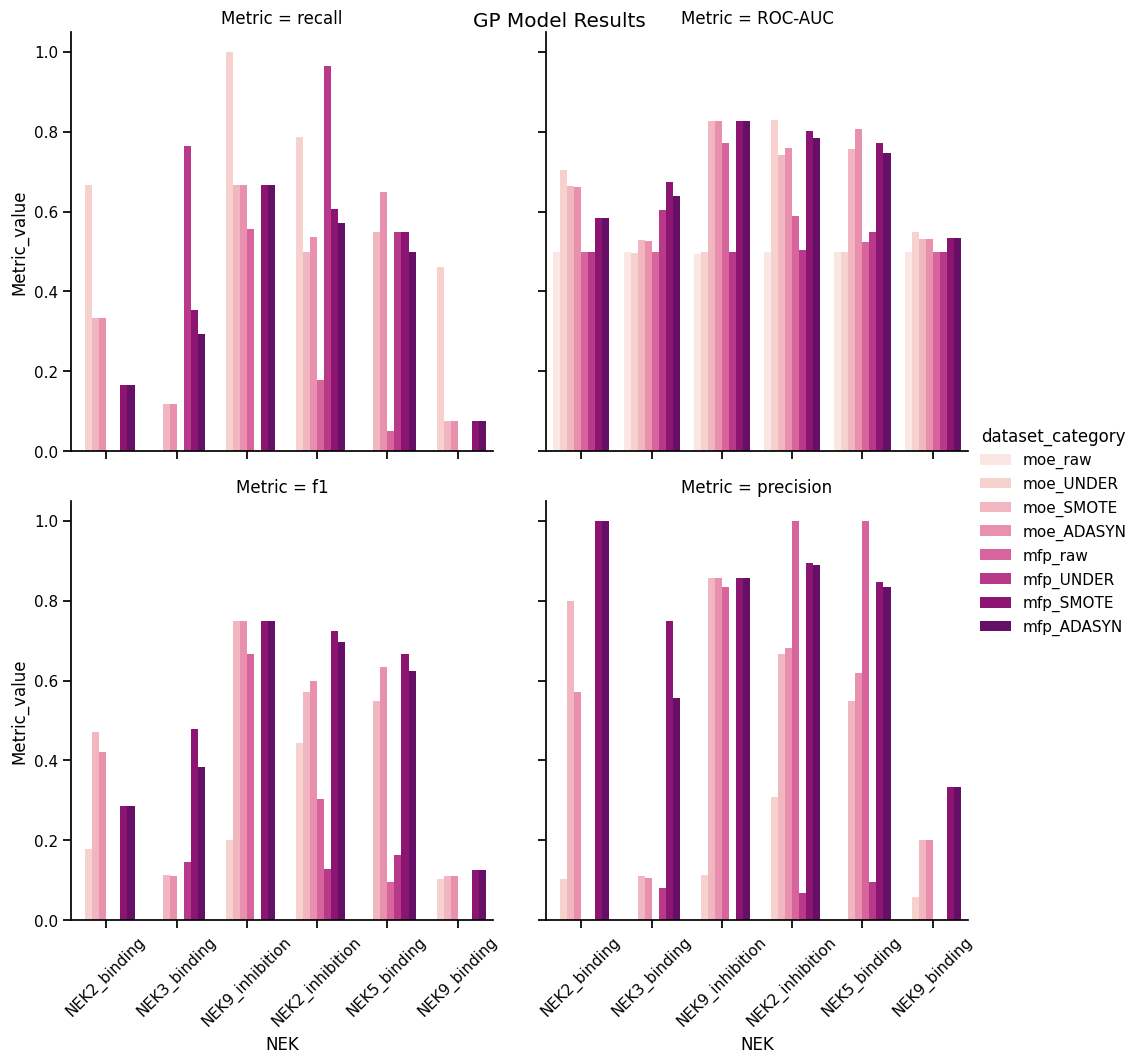

In [590]:
dflong=plot_df.melt(id_vars=['NEK', 'dataset_category', 'model'], value_vars=['recall', 'f1', 'ROC-AUC', 'precision'],
           var_name='Metric', value_name='Metric_value')
dflong=dflong.sort_values('dataset_category', ascending=False)
# display(dflong)

sns.set_context('notebook')
sns.set_palette('colorblind')
# grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=3, s=70, jitter=0.2)
grid=sns.catplot(dflong, x='NEK', y='Metric_value', hue='dataset_category', col='Metric',  kind='bar', col_wrap=2,palette=metric_palette2)
# plt.ylabel('Recall Score')
# kwargs={'loc':(0.79, 0.15)}
# sns.move_legend(grid, (0.6, 0.15))
# grid.fig.subplots_adjust(top=0.95)
for ax in grid.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
# plt.xticks(rotation=80)  
grid.fig.suptitle(f'GP Model Results');
# plt.savefig(f"figures/GP_plots/GP_NEK_recall_scores.png")

plt.show();
    

# Same plot above but just for recall
recall scores for each NEK dataset

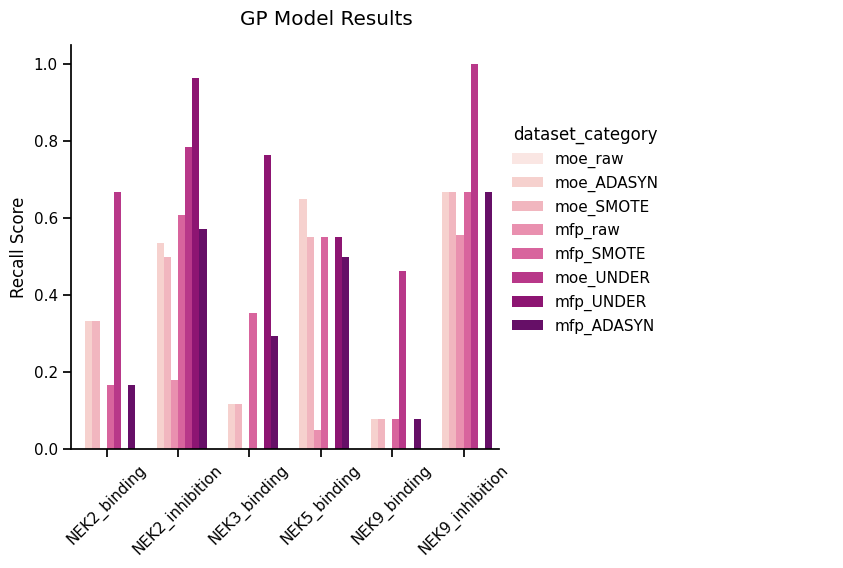

In [591]:
# plot_df = plot_df.sort_values('train actives/total%')
dflong=plot_df.melt(id_vars=['NEK', 'dataset_category', 'model'], value_vars=['recall'],
           var_name='Metric', value_name='Metric_value')
dflong=dflong.sort_values('dataset_category', ascending=False)

# display(dflong)

sns.set_context('notebook')
sns.set_palette('colorblind')
dflong = dflong.sort_values('NEK')
# grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=3, s=70, jitter=0.2)
grid=sns.catplot(dflong, x='NEK', y='Metric_value', hue='dataset_category', col='Metric',  kind='bar', col_wrap=2,palette=metric_palette2)

plt.ylabel('Recall Score')
# kwargs={'loc':(0.79, 0.15)}
sns.move_legend(grid, (0.6, 0.4))
grid.fig.subplots_adjust(top=0.95)
for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        ax.set_title('')
    ax.set_xlabel('')
        # ax.get_title().remove()
# plt.xticks(rotation=80)  
grid.fig.suptitle(f'GP Model Results',x=0.3,y=1.02);
plt.savefig(f"figures/GP_plots/GP_NEK_recall_scores.png",bbox_inches='tight')

plt.show();
    

# recall scores for each nek dataset

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2443702910.py:5: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)


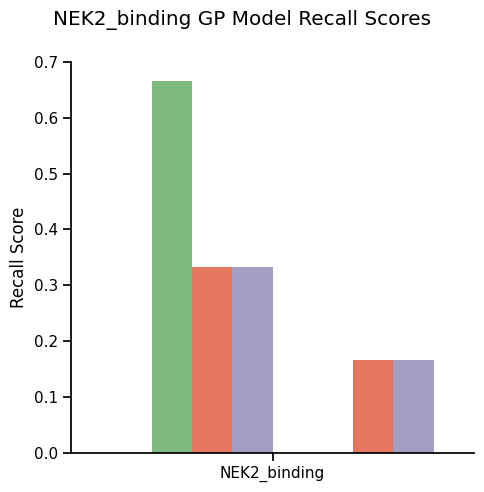

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2443702910.py:5: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)


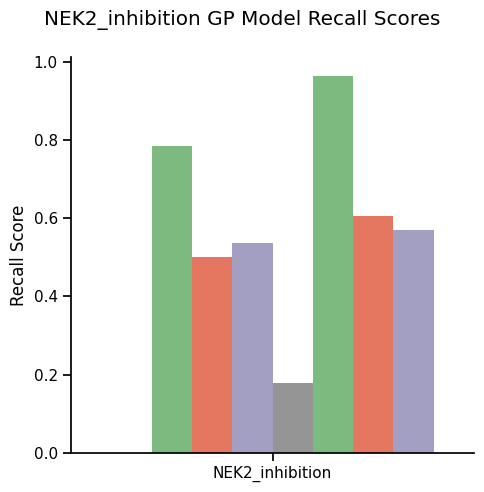

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2443702910.py:5: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)


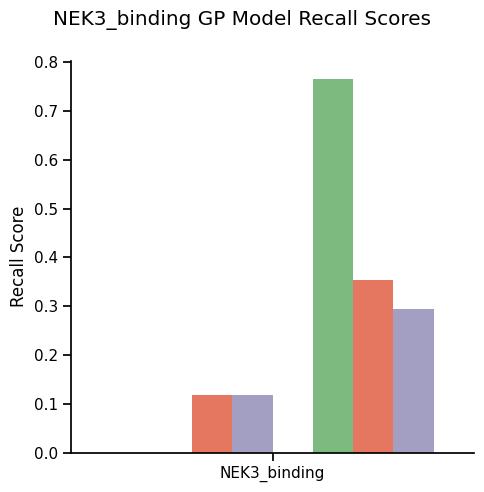

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2443702910.py:5: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)


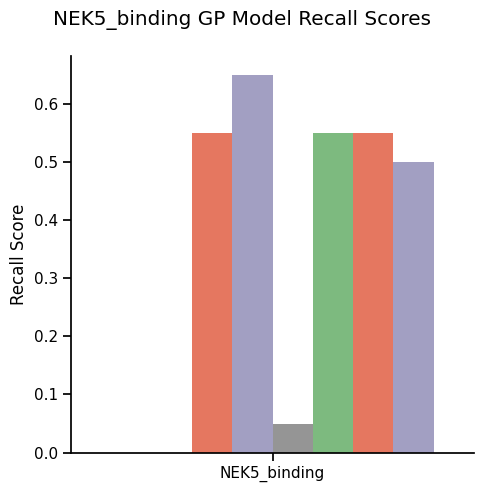

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2443702910.py:5: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)


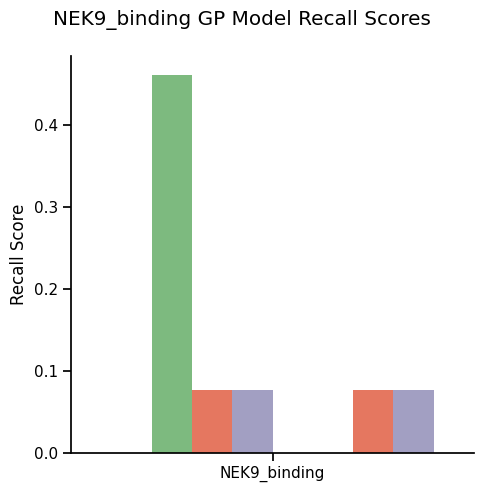

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/2443702910.py:5: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)


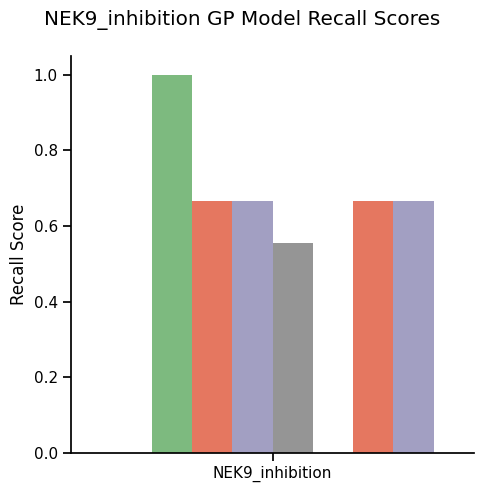

In [592]:

neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
for n, nek in enumerate(neks): 
    nek_df = plot_df[plot_df['NEK'] ==nek]
    # pl = sns.catplot(data=plot_df,x='NEK', y='recall', hue='strategy', col='feat_type', kind='bar')
    pl = sns.catplot(data=nek_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=sampling_palette,legend_out=False)
    for ax in pl.axes.flat:
        # for label in ax.get_xticklabels():
        #     label.set_rotation(80)
        ax.set(xlabel='')
        if ax.get_legend(): 
            ax.get_legend().remove()
    plt.suptitle(f'{nek} GP Model Recall Scores')
    # plt.legend(loc='center right')
    # pl._legend.set_bbox_to_anchor([1.15, 0.5])
    
    # pl._legend.set_frame_on(False)
    plt.subplots_adjust(top=0.9)
    plt.ylabel('Recall Score')
    
    plt.tight_layout()
    plt.savefig(f"figures/GP_plots/GP_{nek}_recall_scores_individ.png",bbox_inches='tight')
    plt.show();


# Recall scores for each model, but subplot for moe and mfp separately

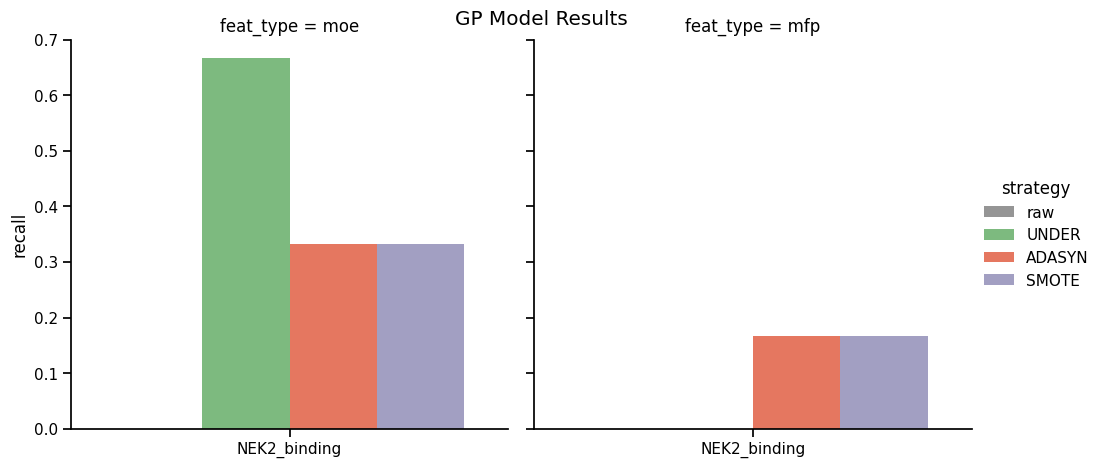

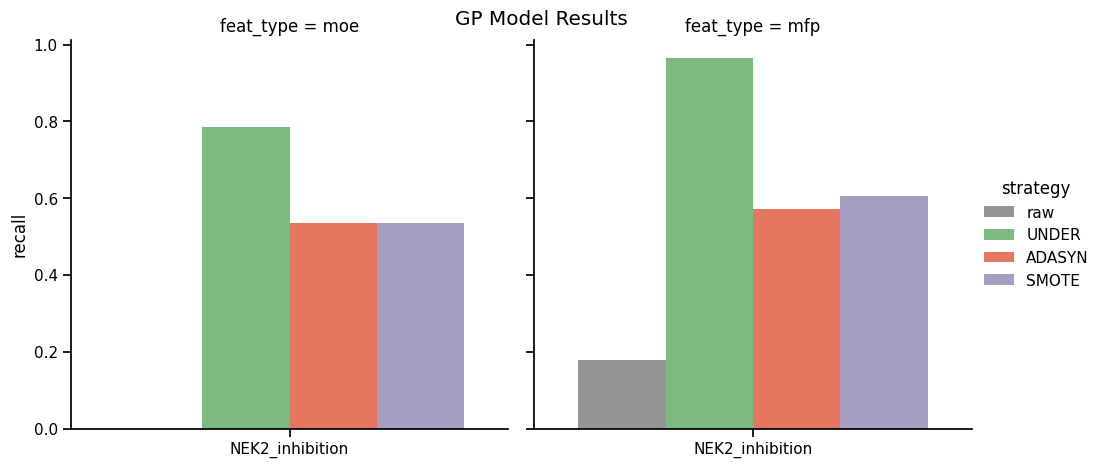

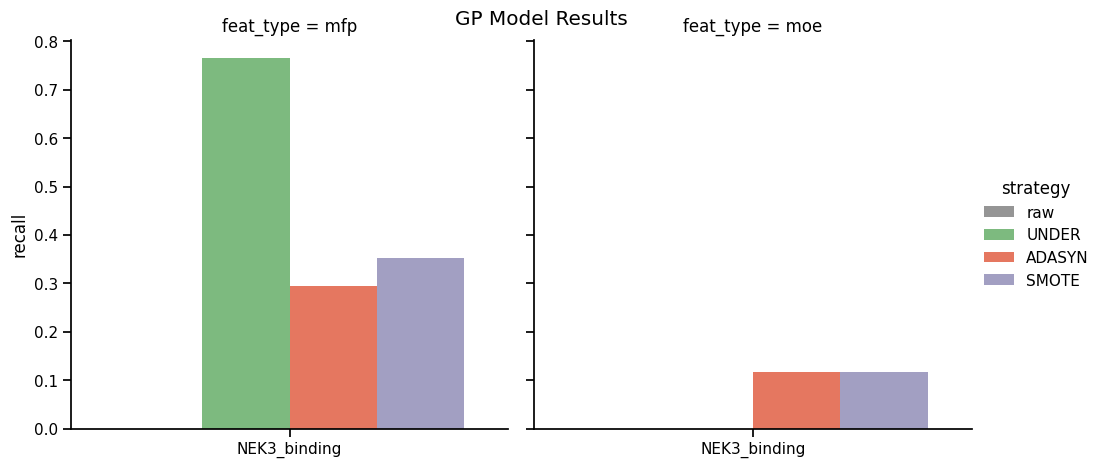

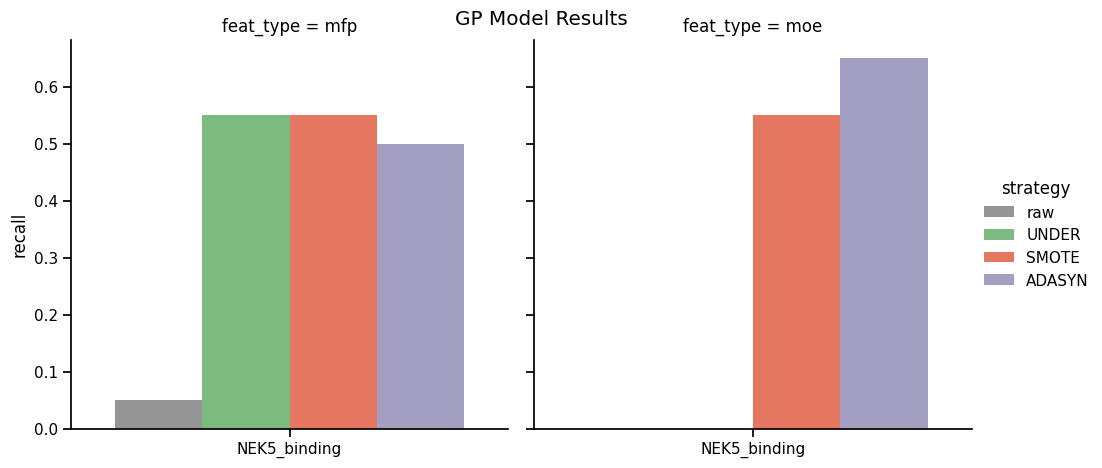

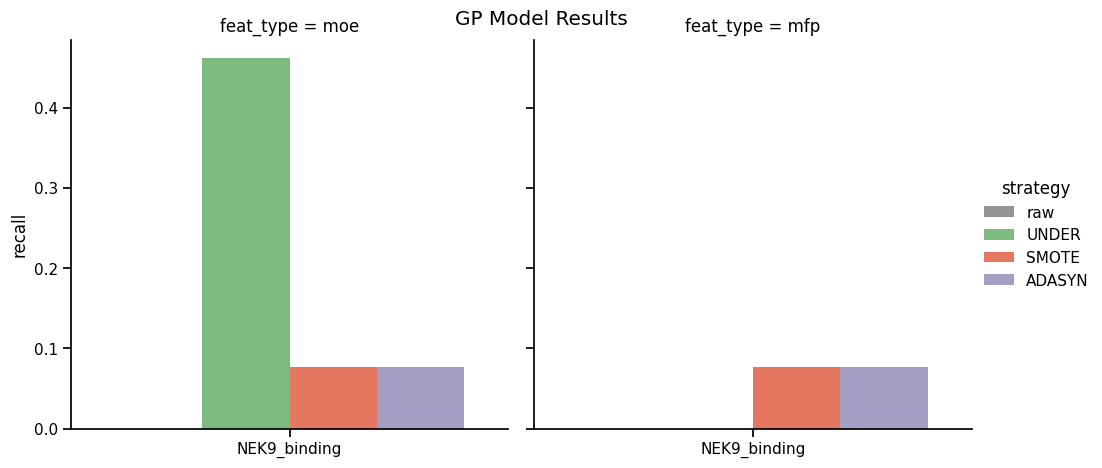

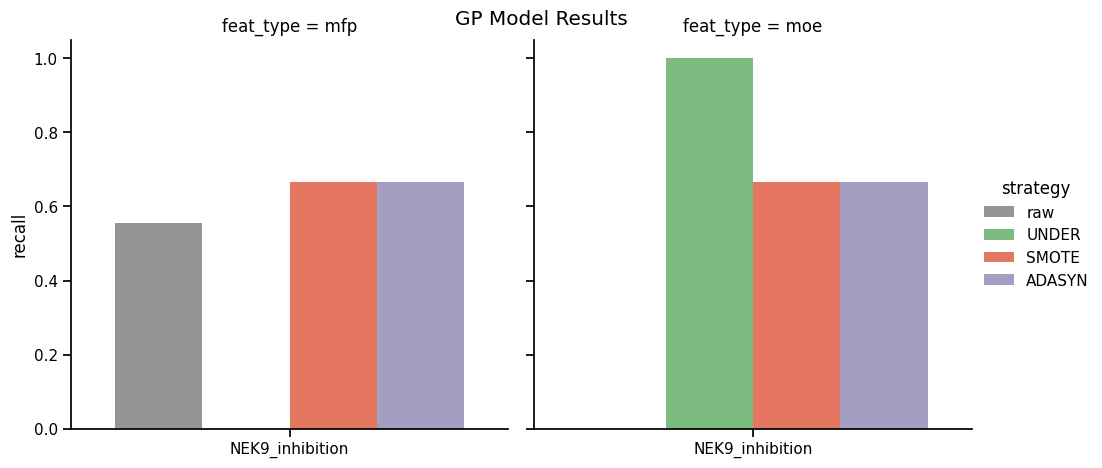

In [463]:
# plt.bar(df['model'], df['recall'])

# value_vars=['accuracy','precision', 'recall','specificity', 'ROC-AUC', 'MCC', 'Balanced Accuracy','f1']
value_vars=['recall']
for n, nek in enumerate(neks): 
    nek_df = plot_df[plot_df['NEK'] ==nek]
    dflong=nek_df.melt(id_vars=['NEK', 'dataset_category', 'strategy','model'], value_vars=['recall'],
           var_name='Metric', value_name='Metric_value')
    dflong=dflong.sort_values('dataset_category', ascending=False)
    # display(dflong)
    sns.set_context('notebook')
    sns.set_palette('colorblind')

    grid=sns.catplot(data=nek_df,x='NEK', y='recall', hue='strategy', col='feat_type', kind='bar',palette=sampling_palette)
    for ax in grid.axes.flat:
        ax.set(xlabel='')
        # for label in ax.get_xticklabels():
        #     label.set_rotation(80)
    plt.ylabel('Recall Score')
    # plt.ylabel('Recall Score')
    # kwargs={'loc':(0.79, 0.15)}
    # sns.move_legend(grid, (0.6, 0.15))
    # grid.fig.subplots_adjust(top=0.95)
    # plt.xticks(rotation=80)  
    grid.fig.suptitle(f'GP Model Results');

# all nek recall scores dataset type as barcolors  

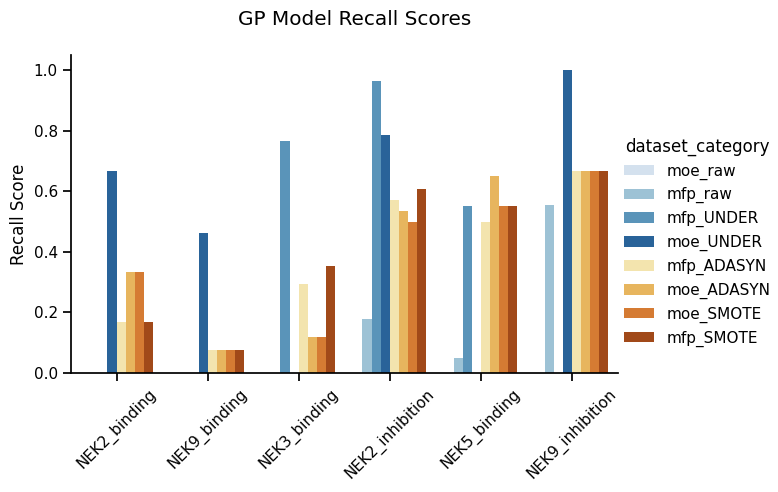

In [593]:
# pl = sns.catplot(data=plot_df,x='NEK', y='recall', hue='strategy', col='feat_type', kind='bar') # subplots ofr moe and mfp 
plot_df = plot_df.sort_values('total actives/total%')
pl = sns.catplot(data=plot_df,x='NEK', y='recall', hue='dataset_category', kind='bar',palette=dataset_palette) # all on one plot
for ax in pl.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set(xlabel='')
plt.suptitle(f'GP Model Recall Scores',x=0.55)
pl._legend.set_bbox_to_anchor([1.19, 0.5])

plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.ylabel('Recall Score')
plt.savefig(f"figures/GP_plots/GP_recall_scores_all_NEK_sorted.png",bbox_inches='tight')
plt.show();


# Comparing recall scores 


NEK2_binding


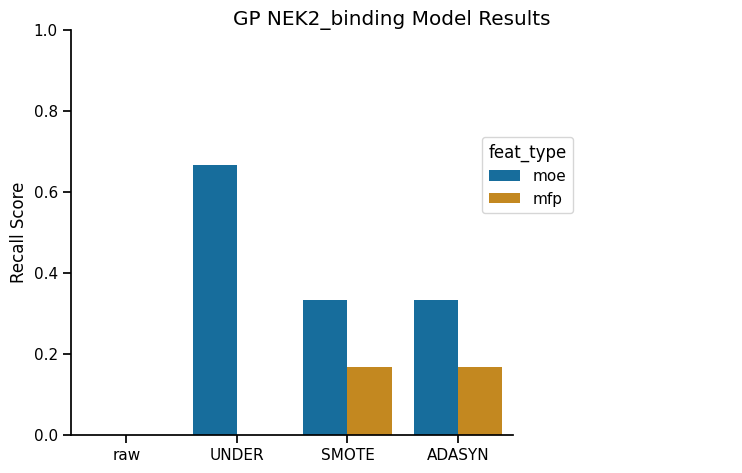


NEK2_inhibition


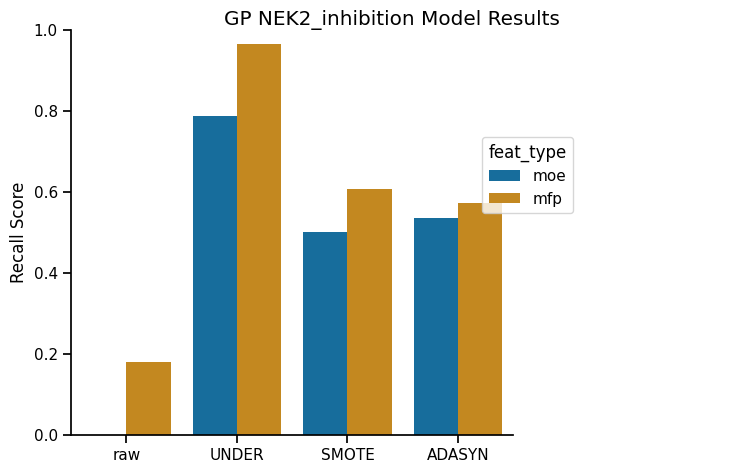


NEK3_binding


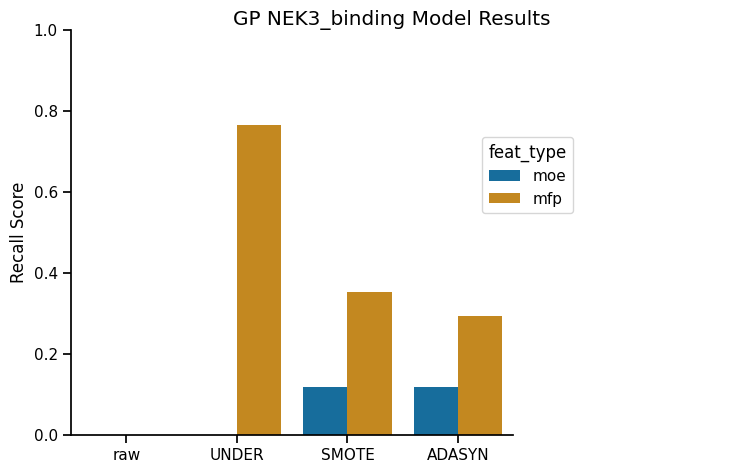


NEK5_binding


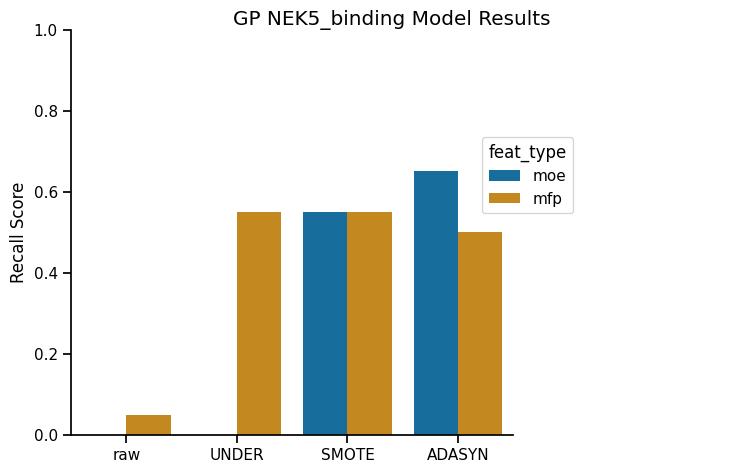


NEK9_binding


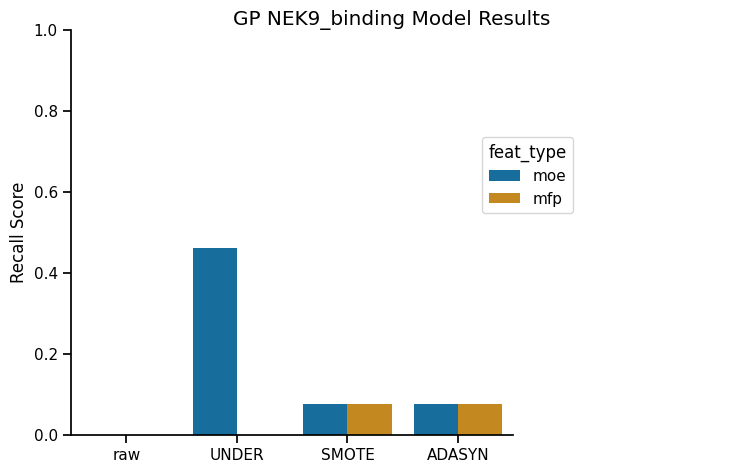


NEK9_inhibition


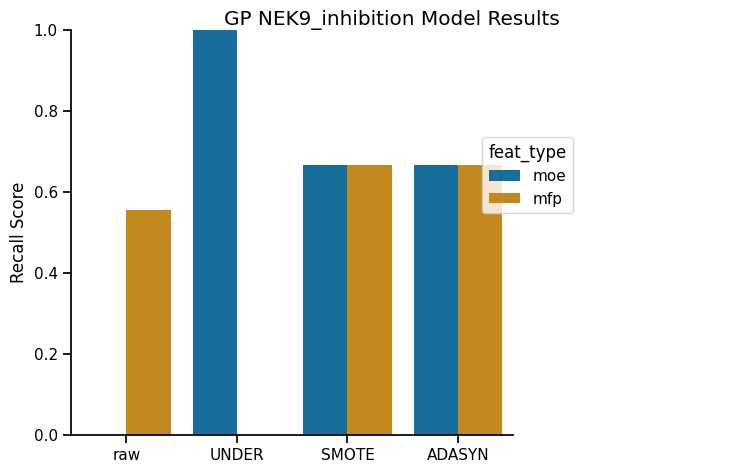

In [594]:
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
# value_vars=['accuracy','precision', 'recall','specificity', 'ROC-AUC', 'MCC', 'Balanced Accuracy','f1']
value_vars=['recall']
for n, nek in enumerate(neks): 
    nek_df = test_df[test_df['NEK'] ==nek]
    print(nek)
    dflong=nek_df.melt(id_vars=['strategy', 'feat_type', 'model'], value_vars=['recall'],
           var_name='Metric', value_name='Metric_value')
    # dflong=dflong.sort_values('Metric')
    
    # display(dflong)
    sns.set_context('notebook')
    sns.set_palette('colorblind')
    # grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=3, s=70, jitter=0.2)
    grid=sns.catplot(dflong, x='strategy', y='Metric_value', hue='feat_type', col='Metric',  kind='bar', col_wrap=2, legend_out=False)
    for ax in grid.axes.flat:
        # for label in ax.get_xticklabels():
        #     label.set_rotation(80)
        ax.set(xlabel='')
        ax.set_title('')
        if ax.get_legend(): 
            ax.get_legend().remove()
        ax.set(ylim=(0,1))
        
    plt.ylabel('Recall Score')
    
    # kwargs={'loc':(0.79, 0.15)}
    sns.move_legend(grid, (0.65, 0.55))
    grid.fig.subplots_adjust(top=0.95)
    grid.fig.suptitle(f'GP {nek} Model Results',x=0.4,y=.99);
    plt.savefig(f"figures/GP_plots/GP_{nek}_metrics_catplot_splitmoemfp.png")
    
    plt.show();
    
    print()

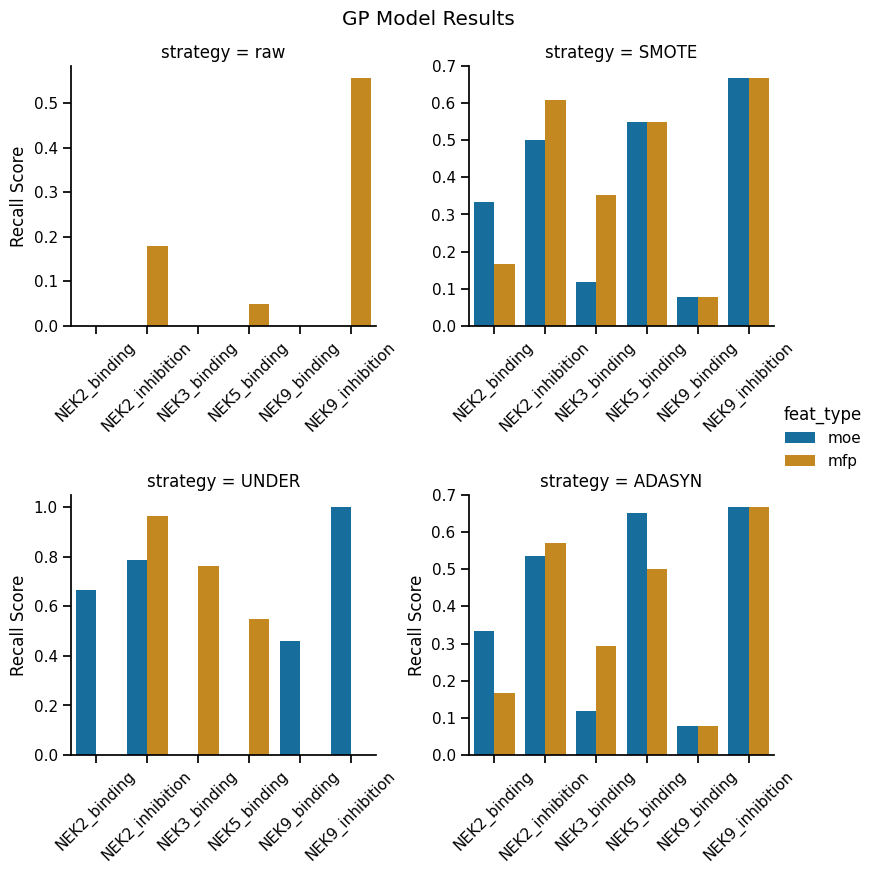

In [595]:
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
# value_vars=['accuracy','precision', 'recall','specificity', 'ROC-AUC', 'MCC', 'Balanced Accuracy','f1']
value_vars=['recall']

dflong=plot_df.melt(id_vars=['strategy', 'feat_type', 'model','NEK'], value_vars=['recall'],
       var_name='Metric', value_name='Recall Score')
dflong=dflong.sort_values('NEK')
grid=sns.catplot(dflong, x='NEK', y='Recall Score', hue='feat_type', col='strategy',  kind='bar', col_wrap=2,height=4,sharex=False, sharey=False)
# sns.move_legend(grid, (0.9, 0.5))
plt.ylabel('Recall Score')
grid.fig.subplots_adjust(hspace=0.65)
grid.fig.subplots_adjust(top=0.95)
for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set(xlabel='')
grid.fig.suptitle(f'GP Model Results', y=1.02)
# grid=sns.move_legend(grid, (1.1, 0.55))
plt.savefig(f"figures/GP_plots/GP_NEK_recall_by_strategy.png",bbox_inches='tight')

plt.show();

print()

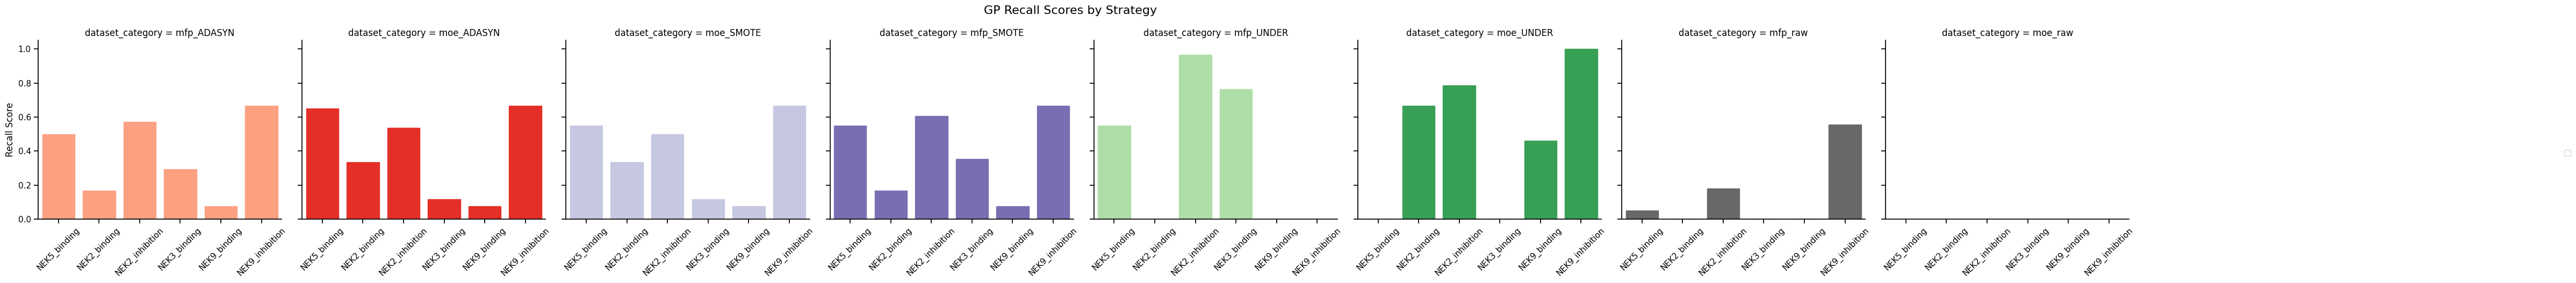

In [596]:
raws = sns.color_palette('Grays', 2) 
smotes = sns.color_palette('Greens', 2)
unders = sns.color_palette('Reds',2) # Purples, RdPu, Reds, YlGn, YlGnBu, YlOrBr, YlOrRd, BuPu, BuGn , dark:salmon_r
adasyns = sns.color_palette('Purples',2)
strategy_palette = raws+smotes+unders+adasyns
strategies = plot_df['dataset_category'].unique()
strategy_colors = dict(zip(strategies, strategy_palette))
# plot_df = plot_df.sort_values('NEK')
plot_df = plot_df.sort_values('strategy')
g2 = sns.catplot(data=plot_df, x='NEK', y='recall', hue='NEK', col='dataset_category', kind='bar', errorbar=None)
for ax in g2.axes.flat:
    ax.set_ylabel('Recall Score')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

    ax.set_xlabel('')
    strategy = ax.get_title().split(' = ')[1]
    bars = ax.patches
    for bar, color in zip(bars, [strategy_colors[strategy]]*len(bars)):
        bar.set_color(color)
    legend = ax.get_legend()
    if legend:
        legend.remove()

handles, labels = ax.get_legend_handles_labels()
g2.fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

g2.fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.suptitle('GP Recall Scores by Strategy', y=1.05, fontsize=16)
# plt.savefig(f"figures/GP_plots/GP_NEK_recall_by_strategy.png", bbox_inches='tight')
plt.show()


# Recall by strategy

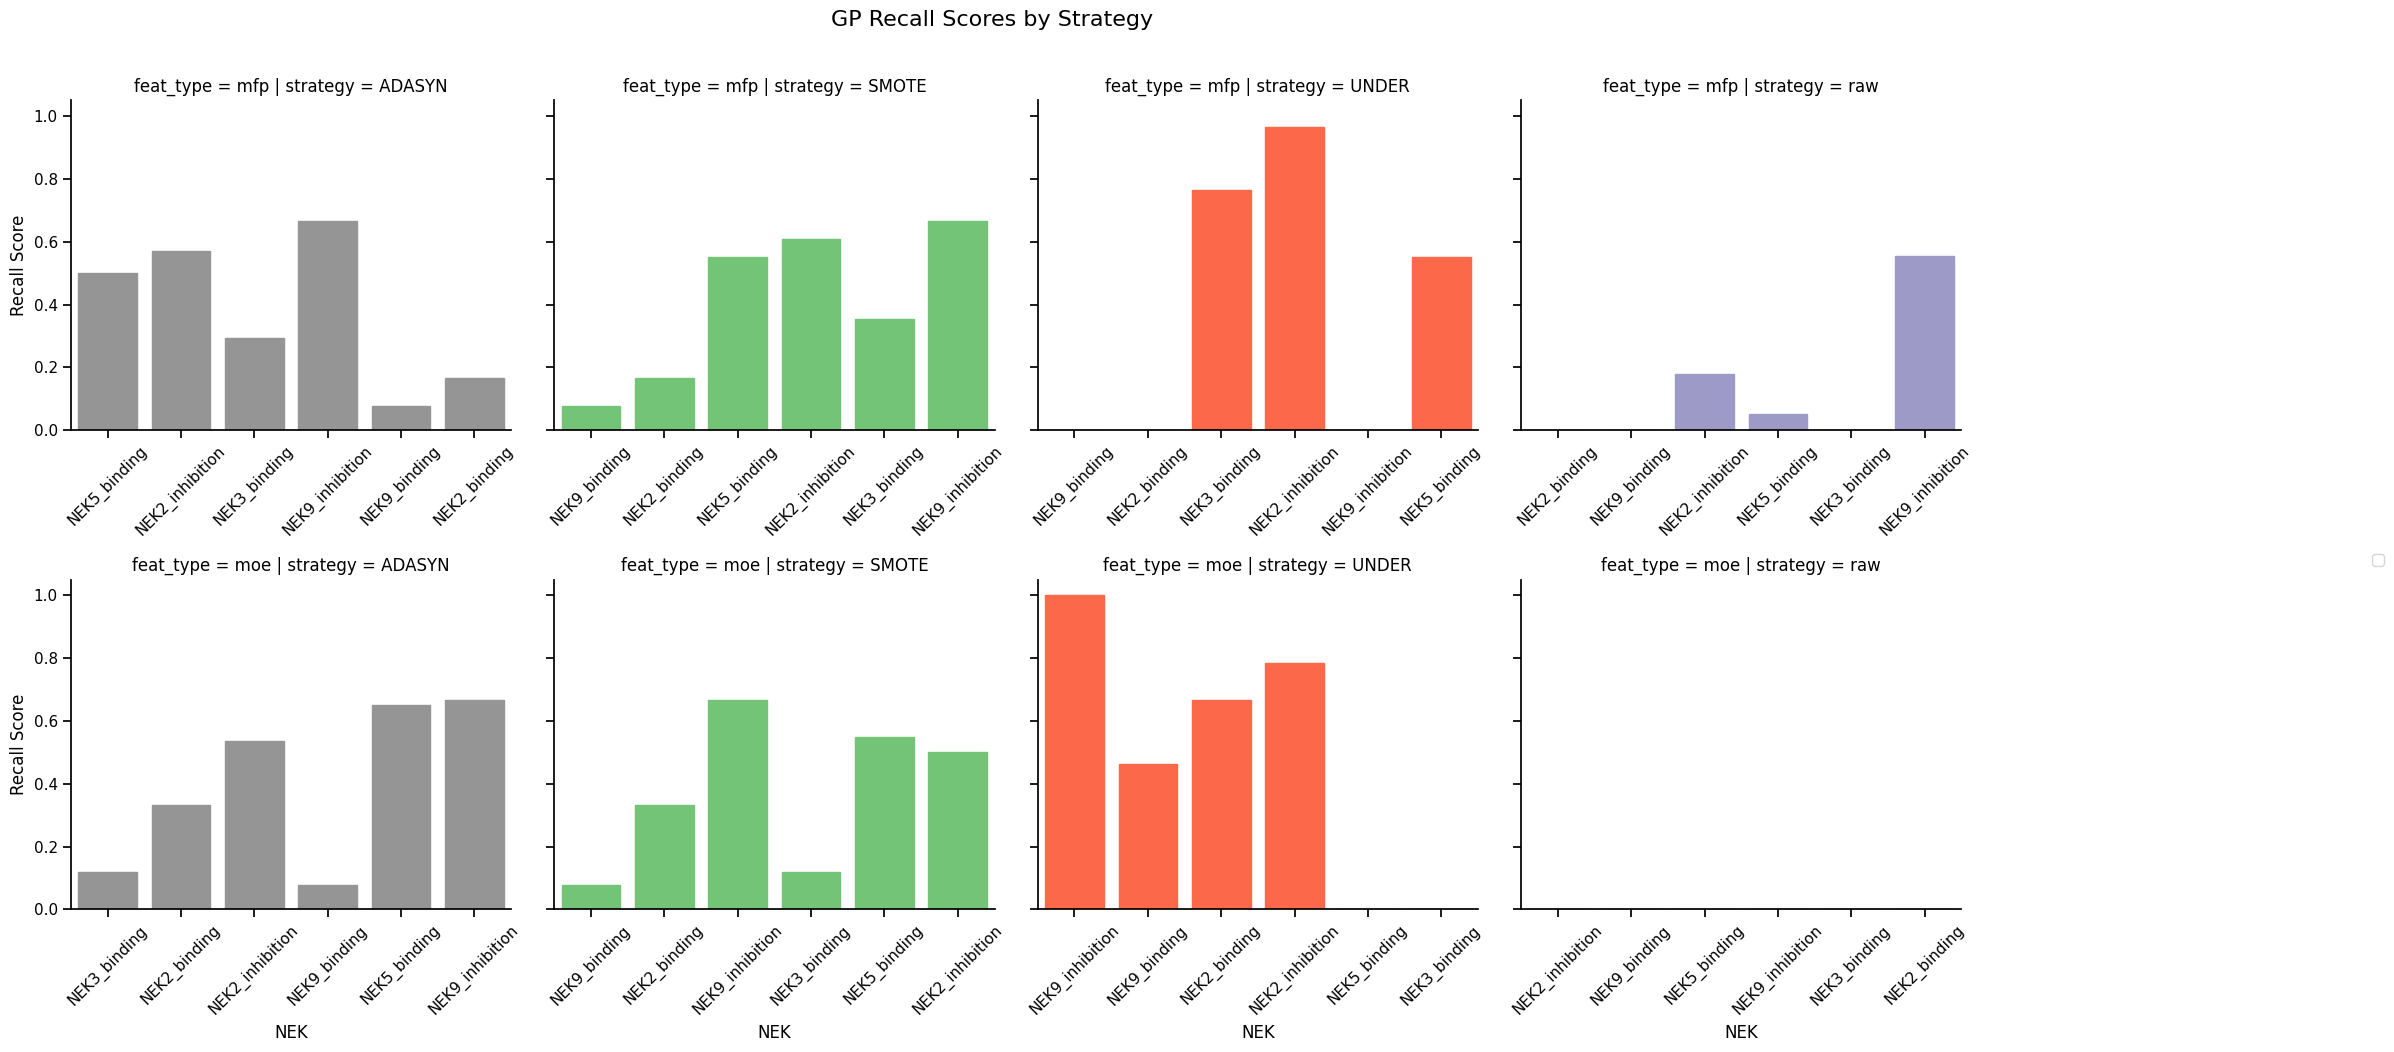

In [607]:
raws = sns.color_palette('Grays', 1) 
smotes = sns.color_palette('Greens', 1)
unders = sns.color_palette('Reds',1) # Purples, RdPu, Reds, YlGn, YlGnBu, YlOrBr, YlOrRd, BuPu, BuGn , dark:salmon_r
adasyns = sns.color_palette('Purples',1)
strategy_palette = raws+smotes+unders+adasyns
strategies = plot_df['strategy'].unique()
strategy_colors = dict(zip(strategies, strategy_palette))
plot_df = plot_df.sort_values('strategy')
g2 = sns.catplot(data=plot_df, x='NEK', y='recall', hue='NEK', row='feat_type',col='strategy', kind='bar', sharex=False,errorbar=None)
for ax in g2.axes.flat:
    ax.set_ylabel('Recall Score')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

    # ax.set_xlabel('')
    strategy = ax.get_title().split(' ')[6]
    bars = ax.patches
    bars = ax.patches
    for bar in bars:
        bar.set_color(strategy_colors[strategy])
    legend = ax.get_legend()
    if legend:
        legend.remove()

handles, labels = ax.get_legend_handles_labels()
g2.fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

g2.fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.suptitle('GP Recall Scores by Strategy', y=1.05, fontsize=16)
# plt.savefig(f"figures/GP_plots/GP_NEK_recall_by_strategy.png", bbox_inches='tight')
plt.show()


# Comparison of imbalance

In [448]:

# for n, nek in enumerate(neks): 
#     nek_df = plot_df[plot_df['NEK'] ==nek]
#     plt.figure()
#     print(nek)
    
#     g = sns.scatterplot(data=nek_df, x='precision', y='recall', hue='strategy', size='percent_active', style=None, palette=None, hue_order=None, hue_norm=None, 
#                         sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None)
#     # g = sns.scatterplot(data=nek_df, x='percent_active', y='recall', hue='strategy', size='feat_type', style=None, palette=None, hue_order=None, hue_norm=None, 
#     #                     sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None)
#     # sns.move_legend(grid, (1, 0.15))
#     plt.legend(loc='upper center')
#     # g.fig.subplots_adjust(top=0.95)
    
    
#     plt.show();
    


In [608]:
plot_df['NEK#'] = plot_df['NEK'].str[0:4]
# plot_df['NEK_strat'] = plot_df['NEK'].str().concat(plot_df[')

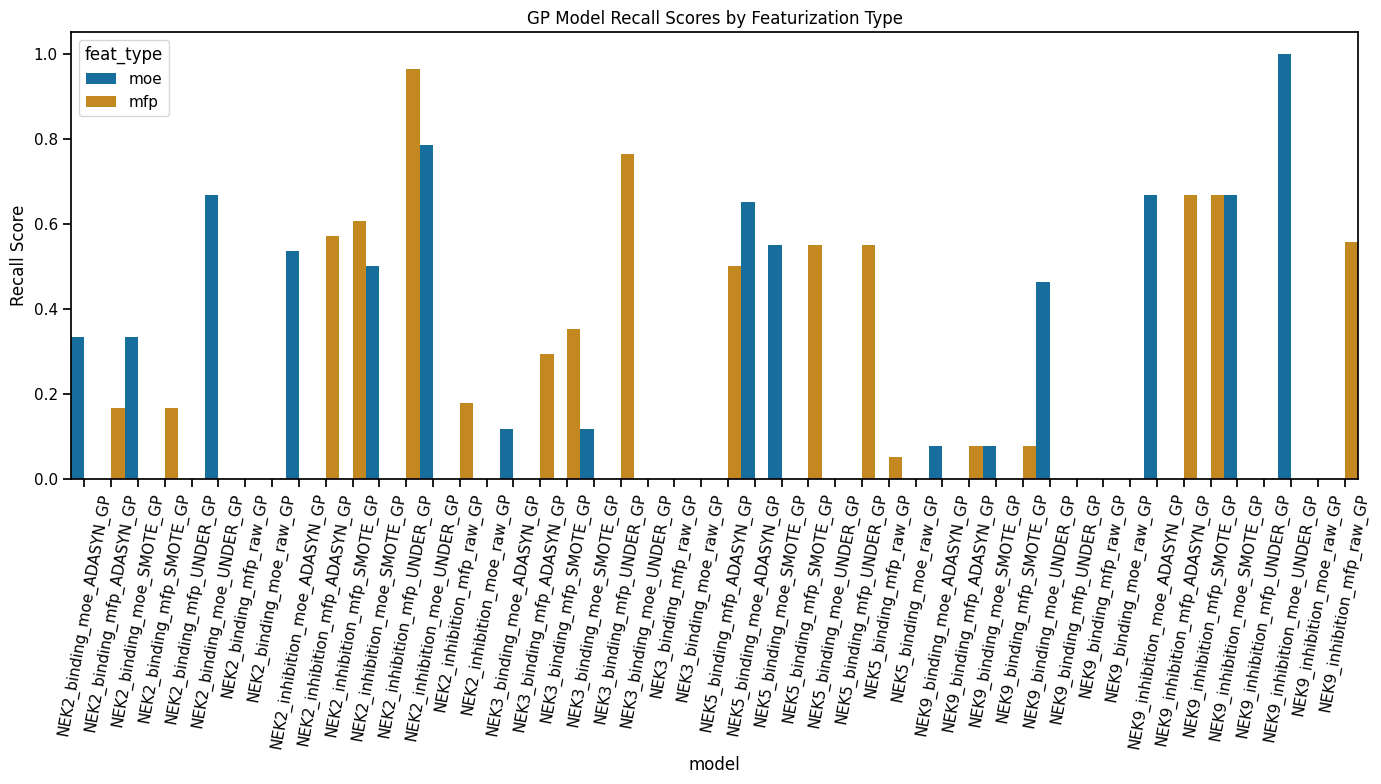

In [609]:
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
dflong=plot_df.melt(id_vars=['NEK#','NEK','dataset_category','model', 'feat_type', 'strategy'], value_vars=['recall'],
       var_name='Metric', value_name='Metric_value')
dflong=dflong.sort_values('Metric')
dflong = dflong.sort_values(by=['NEK', 'strategy'], ascending=[True, True])
# dflong =dflong.sort_values('strategy')
sns.set_context('notebook')
sns.set_palette('colorblind')

# grid=sns.catplot(dflong, x='model', y='Metric_value', hue='feat_type', col='strategy',  kind='bar', col_wrap=2)
plt.figure(figsize=(14, 8))
sns.barplot(data=dflong, x='model', y='Metric_value', hue='feat_type', dodge=True, width=1.)

plt.ylabel('Recall Score')
# kwargs={'loc':(0.79, 0.15)}
sns.move_legend(grid, (0.9, 0.15))
grid.fig.subplots_adjust(top=0.95)

for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(80)
plt.xticks(rotation=80)
plt.title('GP Model Recall Scores by Featurization Type')
plt.tight_layout()
# grid.fig.suptitle(f'GP Model Results {nek}');
plt.savefig(f"figures/GP_plots/GP_all_recall_moemfp.png")

plt.show();

print()


In [610]:
print('GP average recall scores')
for nek in neks: 
    nek_df = test_df[test_df['NEK']==nek]
    average_recall = nek_df['recall'].mean()
    print(f'{nek} average recall score: {average_recall}')

GP average recall scores
NEK2_binding average recall score: 0.20833333333333331
NEK2_inhibition average recall score: 0.5178571428571428
NEK3_binding average recall score: 0.20588235294117646
NEK5_binding average recall score: 0.35625000000000007
NEK9_binding average recall score: 0.09615384615384615
NEK9_inhibition average recall score: 0.5277777777777777


In [611]:
for n in neks: 
    print(n)
    cols = ['NEK', 'feat_type', 'strategy',	'precision',	'recall','cm']
    csv_df = test_df[test_df['NEK']==n]
    grouped_by = csv_df.groupby('strategy')
    for n, gr in grouped_by: 
        display(gr[cols])
    print()
        

NEK2_binding


,NEK,feat_type,strategy,precision,recall,cm
3,NEK2_binding,moe,ADASYN,0.571429,0.333333,"[268, 3, 8, 4]"
7,NEK2_binding,mfp,ADASYN,1.000000,0.166667,"[271, 0, 10, 2]"


,NEK,feat_type,strategy,precision,recall,cm
2,NEK2_binding,moe,SMOTE,0.8,0.333333,"[270, 1, 8, 4]"
6,NEK2_binding,mfp,SMOTE,1.0,0.166667,"[271, 0, 10, 2]"


,NEK,feat_type,strategy,precision,recall,cm
1,NEK2_binding,moe,UNDER,0.102564,0.666667,"[201, 70, 4, 8]"
5,NEK2_binding,mfp,UNDER,0.000000,0.000000,"[270, 1, 12, 0]"


,NEK,feat_type,strategy,precision,recall,cm
0,NEK2_binding,moe,raw,0.0,0.0,"[271, 0, 12, 0]"
4,NEK2_binding,mfp,raw,0.0,0.0,"[271, 0, 12, 0]"



NEK2_inhibition


,NEK,feat_type,strategy,precision,recall,cm
11,NEK2_inhibition,moe,ADASYN,0.681818,0.535714,"[374, 7, 13, 15]"
15,NEK2_inhibition,mfp,ADASYN,0.888889,0.571429,"[379, 2, 12, 16]"


,NEK,feat_type,strategy,precision,recall,cm
10,NEK2_inhibition,moe,SMOTE,0.666667,0.500000,"[374, 7, 14, 14]"
14,NEK2_inhibition,mfp,SMOTE,0.894737,0.607143,"[379, 2, 11, 17]"


,NEK,feat_type,strategy,precision,recall,cm
9,NEK2_inhibition,moe,UNDER,0.309859,0.785714,"[332, 49, 6, 22]"
13,NEK2_inhibition,mfp,UNDER,0.068878,0.964286,"[16, 365, 1, 27]"


,NEK,feat_type,strategy,precision,recall,cm
8,NEK2_inhibition,moe,raw,0.0,0.000000,"[381, 0, 28, 0]"
12,NEK2_inhibition,mfp,raw,1.0,0.178571,"[381, 0, 23, 5]"



NEK3_binding


,NEK,feat_type,strategy,precision,recall,cm
19,NEK3_binding,moe,ADASYN,0.105263,0.117647,"[248, 17, 15, 2]"
23,NEK3_binding,mfp,ADASYN,0.555556,0.294118,"[261, 4, 12, 5]"


,NEK,feat_type,strategy,precision,recall,cm
18,NEK3_binding,moe,SMOTE,0.111111,0.117647,"[249, 16, 15, 2]"
22,NEK3_binding,mfp,SMOTE,0.750000,0.352941,"[263, 2, 11, 6]"


,NEK,feat_type,strategy,precision,recall,cm
17,NEK3_binding,moe,UNDER,0.00000,0.000000,"[263, 2, 17, 0]"
21,NEK3_binding,mfp,UNDER,0.08125,0.764706,"[118, 147, 4, 13]"


,NEK,feat_type,strategy,precision,recall,cm
16,NEK3_binding,moe,raw,0.0,0.0,"[265, 0, 17, 0]"
20,NEK3_binding,mfp,raw,0.0,0.0,"[265, 0, 17, 0]"



NEK5_binding


,NEK,feat_type,strategy,precision,recall,cm
27,NEK5_binding,moe,ADASYN,0.619048,0.65,"[220, 8, 7, 13]"
31,NEK5_binding,mfp,ADASYN,0.833333,0.50,"[226, 2, 10, 10]"


,NEK,feat_type,strategy,precision,recall,cm
26,NEK5_binding,moe,SMOTE,0.550000,0.55,"[219, 9, 9, 11]"
30,NEK5_binding,mfp,SMOTE,0.846154,0.55,"[226, 2, 9, 11]"


,NEK,feat_type,strategy,precision,recall,cm
25,NEK5_binding,moe,UNDER,0.000000,0.00,"[228, 0, 20, 0]"
29,NEK5_binding,mfp,UNDER,0.096491,0.55,"[125, 103, 9, 11]"


,NEK,feat_type,strategy,precision,recall,cm
24,NEK5_binding,moe,raw,0.0,0.00,"[228, 0, 20, 0]"
28,NEK5_binding,mfp,raw,1.0,0.05,"[228, 0, 19, 1]"



NEK9_binding


,NEK,feat_type,strategy,precision,recall,cm
35,NEK9_binding,moe,ADASYN,0.200000,0.076923,"[266, 4, 12, 1]"
39,NEK9_binding,mfp,ADASYN,0.333333,0.076923,"[268, 2, 12, 1]"


,NEK,feat_type,strategy,precision,recall,cm
34,NEK9_binding,moe,SMOTE,0.200000,0.076923,"[266, 4, 12, 1]"
38,NEK9_binding,mfp,SMOTE,0.333333,0.076923,"[268, 2, 12, 1]"


,NEK,feat_type,strategy,precision,recall,cm
33,NEK9_binding,moe,UNDER,0.057692,0.461538,"[172, 98, 7, 6]"
37,NEK9_binding,mfp,UNDER,0.000000,0.000000,"[270, 0, 13, 0]"


,NEK,feat_type,strategy,precision,recall,cm
32,NEK9_binding,moe,raw,0.0,0.0,"[270, 0, 13, 0]"
36,NEK9_binding,mfp,raw,0.0,0.0,"[270, 0, 13, 0]"



NEK9_inhibition


,NEK,feat_type,strategy,precision,recall,cm
43,NEK9_inhibition,moe,ADASYN,0.857143,0.666667,"[70, 1, 3, 6]"
47,NEK9_inhibition,mfp,ADASYN,0.857143,0.666667,"[70, 1, 3, 6]"


,NEK,feat_type,strategy,precision,recall,cm
42,NEK9_inhibition,moe,SMOTE,0.857143,0.666667,"[70, 1, 3, 6]"
46,NEK9_inhibition,mfp,SMOTE,0.857143,0.666667,"[70, 1, 3, 6]"


,NEK,feat_type,strategy,precision,recall,cm
41,NEK9_inhibition,moe,UNDER,0.1125,1.0,"[0, 71, 0, 9]"
45,NEK9_inhibition,mfp,UNDER,0.0000,0.0,"[71, 0, 9, 0]"


,NEK,feat_type,strategy,precision,recall,cm
40,NEK9_inhibition,moe,raw,0.000000,0.000000,"[70, 1, 9, 0]"
44,NEK9_inhibition,mfp,raw,0.833333,0.555556,"[70, 1, 4, 5]"


In [612]:
for n in neks: 
    grouped_test_df= test_df[test_df['NEK']==n]
    # display(grouped_test_df)
    print(n)
    # grouped_strat = nekdf.groupby('strategy')['Metric_value'].idxmax()
    grouped_strat = grouped_test_df.loc[grouped_test_df.groupby('strategy')['recall'].idxmax(), ['NEK','strategy','feat_type', 'model','recall']]
    display(grouped_strat)
    print() 

NEK2_binding


,NEK,strategy,feat_type,model,recall
3,NEK2_binding,ADASYN,moe,NEK2_binding_moe_ADASYN_GP,0.333333
2,NEK2_binding,SMOTE,moe,NEK2_binding_moe_SMOTE_GP,0.333333
1,NEK2_binding,UNDER,moe,NEK2_binding_moe_UNDER_GP,0.666667
0,NEK2_binding,raw,moe,NEK2_binding_moe_raw_GP,0.000000



NEK2_inhibition


,NEK,strategy,feat_type,model,recall
15,NEK2_inhibition,ADASYN,mfp,NEK2_inhibition_mfp_ADASYN_GP,0.571429
14,NEK2_inhibition,SMOTE,mfp,NEK2_inhibition_mfp_SMOTE_GP,0.607143
13,NEK2_inhibition,UNDER,mfp,NEK2_inhibition_mfp_UNDER_GP,0.964286
12,NEK2_inhibition,raw,mfp,NEK2_inhibition_mfp_raw_GP,0.178571



NEK3_binding


,NEK,strategy,feat_type,model,recall
23,NEK3_binding,ADASYN,mfp,NEK3_binding_mfp_ADASYN_GP,0.294118
22,NEK3_binding,SMOTE,mfp,NEK3_binding_mfp_SMOTE_GP,0.352941
21,NEK3_binding,UNDER,mfp,NEK3_binding_mfp_UNDER_GP,0.764706
16,NEK3_binding,raw,moe,NEK3_binding_moe_raw_GP,0.000000



NEK5_binding


,NEK,strategy,feat_type,model,recall
27,NEK5_binding,ADASYN,moe,NEK5_binding_moe_ADASYN_GP,0.65
26,NEK5_binding,SMOTE,moe,NEK5_binding_moe_SMOTE_GP,0.55
29,NEK5_binding,UNDER,mfp,NEK5_binding_mfp_UNDER_GP,0.55
28,NEK5_binding,raw,mfp,NEK5_binding_mfp_raw_GP,0.05



NEK9_binding


,NEK,strategy,feat_type,model,recall
35,NEK9_binding,ADASYN,moe,NEK9_binding_moe_ADASYN_GP,0.076923
34,NEK9_binding,SMOTE,moe,NEK9_binding_moe_SMOTE_GP,0.076923
33,NEK9_binding,UNDER,moe,NEK9_binding_moe_UNDER_GP,0.461538
32,NEK9_binding,raw,moe,NEK9_binding_moe_raw_GP,0.000000



NEK9_inhibition


,NEK,strategy,feat_type,model,recall
43,NEK9_inhibition,ADASYN,moe,NEK9_inhibition_moe_ADASYN_GP,0.666667
42,NEK9_inhibition,SMOTE,moe,NEK9_inhibition_moe_SMOTE_GP,0.666667
41,NEK9_inhibition,UNDER,moe,NEK9_inhibition_moe_UNDER_GP,1.000000
44,NEK9_inhibition,raw,mfp,NEK9_inhibition_mfp_raw_GP,0.555556


In [513]:
# GP Model
result_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/GP/GP_results/'
data_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/'
nek_nums = [3,5]
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN'] 
features = ['moe', 'mfp']
NEK= 'NEK'

for i, n in enumerate(nek_nums):
    nek = str(n)
    # print(f'NEK{nek}')
    nek_path= f'{data_dir}NEK{nek}/bind/'
    for k, feat in enumerate(features): 
        print()
        for j, samp in enumerate(samplings): 
        
            print(f'NEK{nek} bind {feat} {samp}')
            file_root = f'NEK{nek}_binding_{feat}_{samp}'
            dfname = file_root+'_df.csv'
            nek35 = pd.read_csv(nek_path+dfname)
            test35 = nek35[nek35['subset']=='test'] 
            test35['active'].value_counts
            print(test35['active'].value_counts())
            print()


NEK3 bind moe scaled
active
0    265
1     17
Name: count, dtype: int64

NEK3 bind moe UNDER
active
0    265
1     17
Name: count, dtype: int64

NEK3 bind moe SMOTE
active
0    265
1     17
Name: count, dtype: int64

NEK3 bind moe ADASYN
active
0    265
1     17
Name: count, dtype: int64


NEK3 bind mfp scaled
active
0    265
1     17
Name: count, dtype: int64

NEK3 bind mfp UNDER
active
0    265
1     17
Name: count, dtype: int64

NEK3 bind mfp SMOTE
active
0    265
1     17
Name: count, dtype: int64

NEK3 bind mfp ADASYN
active
0    265
1     17
Name: count, dtype: int64


NEK5 bind moe scaled
active
0    228
1     20
Name: count, dtype: int64

NEK5 bind moe UNDER
active
0    228
1     20
Name: count, dtype: int64

NEK5 bind moe SMOTE
active
0    228
1     20
Name: count, dtype: int64

NEK5 bind moe ADASYN
active
0    228
1     20
Name: count, dtype: int64


NEK5 bind mfp scaled
active
0    228
1     20
Name: count, dtype: int64

NEK5 bind mfp UNDER
active
0    228
1     20
Name: co

In [454]:
type(pl)

seaborn.axisgrid.FacetGrid

In [455]:
pl?



Type:           FacetGrid
String form:    <seaborn.axisgrid.FacetGrid object at 0x3e595d460>
File:           ~/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/axisgrid.py
Docstring:      Multi-plot grid for plotting conditional relationships.
Init docstring:
Initialize the matplotlib figure and FacetGrid object.

This class maps a dataset onto multiple axes arrayed in a grid of rows
and columns that correspond to *levels* of variables in the dataset.
The plots it produces are often called "lattice", "trellis", or
"small-multiple" graphics.

It can also represent levels of a third variable with the ``hue``
parameter, which plots different subsets of data in different colors.
This uses color to resolve elements on a third dimension, but only
draws subsets on top of each other and will not tailor the ``hue``
parameter for the specific visualization the way that axes-level
functions that accept ``hue`` will.

The basic workflow is to initialize the :class:`FacetGrid` object with


In [456]:
df2 = pd.read_csv('../GP/GP_results/GP_test_results_all_NEK.csv')
df2.shape

(48, 17)

In [109]:
plot_df[['model', 'cm', 'recall', 'NEK']]


,model,cm,recall,NEK
0,NEK2_binding_moe_scaled_GP,"[271, 0, 12, 0]",0.000000,NEK2_binding
1,NEK2_binding_moe_UNDER_GP,"[201, 70, 4, 8]",0.666667,NEK2_binding
2,NEK2_binding_moe_SMOTE_GP,"[271, 0, 8, 4]",0.333333,NEK2_binding
3,NEK2_binding_moe_ADASYN_GP,"[268, 3, 8, 4]",0.333333,NEK2_binding
4,NEK2_binding_mfp_scaled_GP,"[271, 0, 12, 0]",0.000000,NEK2_binding
5,NEK2_binding_mfp_UNDER_GP,"[270, 1, 12, 0]",0.000000,NEK2_binding
6,NEK2_binding_mfp_SMOTE_GP,"[271, 0, 10, 2]",0.166667,NEK2_binding
7,NEK2_binding_mfp_ADASYN_GP,"[271, 0, 10, 2]",0.166667,NEK2_binding
8,NEK2_inhibition_moe_scaled_GP,"[381, 0, 28, 0]",0.000000,NEK2_inhibition
9,NEK2_inhibition_moe_UNDER_GP,"[332, 49, 6, 22]",0.785714,NEK2_inhibition


In [515]:
datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/GP/GP_results/'
df2 = pd.read_csv(datapath+'GP_test_results_all_NEK.csv')
df2['strategy'] = df2['strategy'].str.replace('scaled', 'raw')
df2['model'] = df2['model'].str.replace('scaled', 'raw')
df2.set_index(['NEK',  'strategy', 'feat_type'], inplace=True)
df2 = df2.sort_values(['NEK','strategy'])
# df2 = df2.sort_values('strategy')
display(df2)
df2.to_csv(datapath+'GP_results_by_strategy.csv', index=True)


model  accuracy  \
NEK             strategy feat_type                                            
NEK2_binding    ADASYN   moe           NEK2_binding_moe_ADASYN_GP  0.961131   
                         mfp           NEK2_binding_mfp_ADASYN_GP  0.964664   
                SMOTE    moe            NEK2_binding_moe_SMOTE_GP  0.968198   
                         mfp            NEK2_binding_mfp_SMOTE_GP  0.964664   
                UNDER    moe            NEK2_binding_moe_UNDER_GP  0.738516   
                         mfp            NEK2_binding_mfp_UNDER_GP  0.954064   
                raw      moe              NEK2_binding_moe_raw_GP  0.957597   
                         mfp              NEK2_binding_mfp_raw_GP  0.957597   
NEK2_inhibition ADASYN   moe        NEK2_inhibition_moe_ADASYN_GP  0.951100   
                         mfp        NEK2_inhibition_mfp_ADASYN_GP  0.965770   
                SMOTE    moe         NEK2_inhibition_moe_SMOTE_GP  0.948655   
                         mfp         NEK2_inhibition_mfp_SMOTE_GP  0.968215   
                UNDER    moe         NEK2_inhibition_moe_UNDER_GP  0.865526   
                         mfp         NEK2_inhibition_mfp_UNDER_GP  0.105134   
                raw      moe           NEK2_inhibition_moe_raw_GP  0.931540   
                         mfp           NEK2_inhibition_mfp_raw_GP  0.943765   
NEK3_binding    ADASYN   moe           NEK3_binding_moe_ADASYN_GP  0.886525   
                         mfp           NEK3_binding_mfp_ADASYN_GP  0.943262   
                SMOTE    moe            NEK3_binding_moe_SMOTE_GP  0.890071   
                         mfp            NEK3_binding_mfp_SMOTE_GP  0.953901   
                UNDER    moe            NEK3_binding_moe_UNDER_GP  0.932624   
                         mfp            NEK3_binding_mfp_UNDER_GP  0.464539   
                raw      moe              NEK3_binding_moe_raw_GP  0.939716   
                         mfp              NEK3_binding_mfp_raw_GP  0.939716   
NEK5_binding    ADASYN   moe           NEK5_binding_moe_ADASYN_GP  0.939516   
                         mfp           NEK5_binding_mfp_ADASYN_GP  0.951613   
                SMOTE    moe            NEK5_binding_moe_SMOTE_GP  0.927419   
                         mfp            NEK5_binding_mfp_SMOTE_GP  0.955645   
                UNDER    moe            NEK5_binding_moe_UNDER_GP  0.919355   
                         mfp            NEK5_binding_mfp_UNDER_GP  0.548387   
                raw      moe              NEK5_binding_moe_raw_GP  0.919355   
                         mfp              NEK5_binding_mfp_raw_GP  0.923387   
NEK9_binding    ADASYN   moe           NEK9_binding_moe_ADASYN_GP  0.943463   
                         mfp           NEK9_binding_mfp_ADASYN_GP  0.950530   
                SMOTE    moe            NEK9_binding_moe_SMOTE_GP  0.943463   
                         mfp            NEK9_binding_mfp_SMOTE_GP  0.950530   
                UNDER    moe            NEK9_binding_moe_UNDER_GP  0.628975   
                         mfp            NEK9_binding_mfp_UNDER_GP  0.954064   
                raw      moe              NEK9_binding_moe_raw_GP  0.954064   
                         mfp              NEK9_binding_mfp_raw_GP  0.954064   
NEK9_inhibition ADASYN   moe        NEK9_inhibition_moe_ADASYN_GP  0.950000   
                         mfp        NEK9_inhibition_mfp_ADASYN_GP  0.950000   
                SMOTE    moe         NEK9_inhibition_moe_SMOTE_GP  0.950000   
                         mfp         NEK9_inhibition_mfp_SMOTE_GP  0.950000   
                UNDER    moe         NEK9_inhibition_moe_UNDER_GP  0.112500   
                         mfp         NEK9_inhibition_mfp_UNDER_GP  0.887500   
                raw      moe           NEK9_inhibition_moe_raw_GP  0.875000   
                         mfp           NEK9_inhibition_mfp_raw_GP  0.937500   

                                    precision    recall  specificity   TN  FN  \
NEK             strategy fea

In [516]:
df3 = pd.read_csv(datapath+'GP_test_results_all_NEK.csv')
df3['strategy'] = df3['strategy'].str.replace('scaled', 'raw')
df3['model'] = df3['model'].str.replace('scaled', 'raw')
df3.set_index(['NEK', 'feat_type','strategy'],inplace=True)
df3.sort_values(['NEK','feat_type', 'strategy'], inplace=True)
display(df3)
df3.to_csv(datapath+'GP_results_by_feat_type.csv', index=True)
# df3.to_excel(datapath+'GP_results_by_feat_type.xlsx', index=True)


model  accuracy  \
NEK             feat_type strategy                                            
NEK2_binding    mfp       ADASYN       NEK2_binding_mfp_ADASYN_GP  0.964664   
                          SMOTE         NEK2_binding_mfp_SMOTE_GP  0.964664   
                          UNDER         NEK2_binding_mfp_UNDER_GP  0.954064   
                          raw             NEK2_binding_mfp_raw_GP  0.957597   
                moe       ADASYN       NEK2_binding_moe_ADASYN_GP  0.961131   
                          SMOTE         NEK2_binding_moe_SMOTE_GP  0.968198   
                          UNDER         NEK2_binding_moe_UNDER_GP  0.738516   
                          raw             NEK2_binding_moe_raw_GP  0.957597   
NEK2_inhibition mfp       ADASYN    NEK2_inhibition_mfp_ADASYN_GP  0.965770   
                          SMOTE      NEK2_inhibition_mfp_SMOTE_GP  0.968215   
                          UNDER      NEK2_inhibition_mfp_UNDER_GP  0.105134   
                          raw          NEK2_inhibition_mfp_raw_GP  0.943765   
                moe       ADASYN    NEK2_inhibition_moe_ADASYN_GP  0.951100   
                          SMOTE      NEK2_inhibition_moe_SMOTE_GP  0.948655   
                          UNDER      NEK2_inhibition_moe_UNDER_GP  0.865526   
                          raw          NEK2_inhibition_moe_raw_GP  0.931540   
NEK3_binding    mfp       ADASYN       NEK3_binding_mfp_ADASYN_GP  0.943262   
                          SMOTE         NEK3_binding_mfp_SMOTE_GP  0.953901   
                          UNDER         NEK3_binding_mfp_UNDER_GP  0.464539   
                          raw             NEK3_binding_mfp_raw_GP  0.939716   
                moe       ADASYN       NEK3_binding_moe_ADASYN_GP  0.886525   
                          SMOTE         NEK3_binding_moe_SMOTE_GP  0.890071   
                          UNDER         NEK3_binding_moe_UNDER_GP  0.932624   
                          raw             NEK3_binding_moe_raw_GP  0.939716   
NEK5_binding    mfp       ADASYN       NEK5_binding_mfp_ADASYN_GP  0.951613   
                          SMOTE         NEK5_binding_mfp_SMOTE_GP  0.955645   
                          UNDER         NEK5_binding_mfp_UNDER_GP  0.548387   
                          raw             NEK5_binding_mfp_raw_GP  0.923387   
                moe       ADASYN       NEK5_binding_moe_ADASYN_GP  0.939516   
                          SMOTE         NEK5_binding_moe_SMOTE_GP  0.927419   
                          UNDER         NEK5_binding_moe_UNDER_GP  0.919355   
                          raw             NEK5_binding_moe_raw_GP  0.919355   
NEK9_binding    mfp       ADASYN       NEK9_binding_mfp_ADASYN_GP  0.950530   
                          SMOTE         NEK9_binding_mfp_SMOTE_GP  0.950530   
                          UNDER         NEK9_binding_mfp_UNDER_GP  0.954064   
                          raw             NEK9_binding_mfp_raw_GP  0.954064   
                moe       ADASYN       NEK9_binding_moe_ADASYN_GP  0.943463   
                          SMOTE         NEK9_binding_moe_SMOTE_GP  0.943463   
                          UNDER         NEK9_binding_moe_UNDER_GP  0.628975   
                          raw             NEK9_binding_moe_raw_GP  0.954064   
NEK9_inhibition mfp       ADASYN    NEK9_inhibition_mfp_ADASYN_GP  0.950000   
                          SMOTE      NEK9_inhibition_mfp_SMOTE_GP  0.950000   
                          UNDER      NEK9_inhibition_mfp_UNDER_GP  0.887500   
                          raw          NEK9_inhibition_mfp_raw_GP  0.937500   
                moe       ADASYN    NEK9_inhibition_moe_ADASYN_GP  0.950000   
                          SMOTE      NEK9_inhibition_moe_SMOTE_GP  0.950000   
                          UNDER      NEK9_inhibition_moe_UNDER_GP  0.112500   
                          raw          NEK9_inhibition_moe_raw_GP  0.875000   

                                    precision    recall  specificity   TN  FN  \
NEK             feat_type st

In [219]:
def get_arrays(file_path, df_filename, filename_type=None, save=False,yesPrint=False):
    """use dataframes to get trainX, trainy, testX, testy out. Optional: save those files to csv
    file_path: directory
    df_filename: dataframe NEK#_binding_moe_{sampling}_df.csv (sampling: scaled, UNDER, SMOTE, ADASYN)
    split dataframe to train and test, and x and y
    save: bool, option to save splits to separate csv files (train X, train y, test X, test y) 
    returns: numpy arrays train X, train y, testX, test y"""
    df = pd.read_csv(file_path+df_filename)
    train_df= df[df['subset']=='train']
    test_df = df[df['subset']=='test']
    train_y = train_df['active'].to_numpy().reshape(-1)
    test_y=test_df['active'].to_numpy().reshape(-1)
    train_x_df = train_df.drop(columns='active')
    test_x_df = test_df.drop(columns='active')
    train_x_df = train_df.drop(columns='active')
    test_x_df = test_df.drop(columns='active')
    trainX = train_x_df.select_dtypes(include='number').to_numpy()
    testX = test_x_df.select_dtypes(include='number').to_numpy()

    if yesPrint: 
        print(f'train X shape: {trainX.shape}, y: {train_y.shape}, test X: {testX.shape}, y:{test_y.shape}')
    if (save and filename_type is not None): 
        trainxdf = pd.DataFrame(trainX)
        trainxdf.to_csv(file_path+filename_type+'_trainX.csv', index=False)
        trainy_df = pd.DataFrame(train_y)
        trainy_df.to_csv(file_path+filename_type+'_train_y.csv', index=False) 
        testxdf = pd.DataFrame(testX)
        testxdf.to_csv(file_path+filename_type+'_testX.csv', index=False)
        testy_df = pd.DataFrame(test_y)
        testy_df.to_csv(file_path+filename_type+'_test_y.csv', index=False) 
        
    return trainX, train_y, testX, test_y

data_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/'
nek_nums = [2,3,5,9]
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN'] 
features = ['moe', 'mfp']
NEK= 'NEK'
train_size = [] 
test_size = []
train_actives = [] 
test_actives = [] 
ds_types = []
neknums = []
moe_mfp = [] 
samps = []
for i, n in enumerate(nek_nums):
    nek = str(n)
    print(f'NEK{nek}')
    nek_path= f'{data_dir}NEK{nek}/bind/'
 
    for k, feat in enumerate(features): 
        print()
        for j, samp in enumerate(samplings): 

            file_root = f'NEK{nek}_binding_{feat}_{samp}_df.csv'
            print(file_root) 
            moe_mfp.append(feat)
            samps.append(samp)
            trainX, trainy, testX, testy =  get_arrays(nek_path,file_root)
            train_size.append(trainy.shape[0])
            test_size.append(testy.shape[0])
            neknums.append('NEK'+nek+'_binding')
            train_actives.append(np.count_nonzero(trainy==1))
            test_actives.append(np.count_nonzero(testy==1))                 
            ds_types.append(f'NEK{nek}_binding_{feat}_{samp}')
            
            
      
            print()
            
            
    print()
    
    if n == 2 or n == 9:

        nek_path= f'{data_dir}NEK{nek}/inhib/'
        for k, feat in enumerate(features): 
            print()
            for j, samp in enumerate(samplings): 
                file_root = f'NEK{nek}_inhibition_{feat}_{samp}_df.csv'
                print(file_root) 
                moe_mfp.append(feat)
                samps.append(samp)
                trainX, trainy, testX, testy =  get_arrays(nek_path,file_root)
                train_size.append(trainy.shape[0])
                test_size.append(testy.shape[0])
                neknums.append('NEK'+nek+'_inhibition')
                train_actives.append(np.count_nonzero(trainy==1))
                test_actives.append(np.count_nonzero(testy==1))                 
                ds_types.append(f'NEK{nek}_inhibition_{feat}_{samp}')
            
                print()
            
        
            
    print()

NEK2

NEK2_binding_moe_scaled_df.csv

NEK2_binding_moe_UNDER_df.csv

NEK2_binding_moe_SMOTE_df.csv

NEK2_binding_moe_ADASYN_df.csv


NEK2_binding_mfp_scaled_df.csv

NEK2_binding_mfp_UNDER_df.csv

NEK2_binding_mfp_SMOTE_df.csv

NEK2_binding_mfp_ADASYN_df.csv



NEK2_inhibition_moe_scaled_df.csv

NEK2_inhibition_moe_UNDER_df.csv

NEK2_inhibition_moe_SMOTE_df.csv

NEK2_inhibition_moe_ADASYN_df.csv


NEK2_inhibition_mfp_scaled_df.csv

NEK2_inhibition_mfp_UNDER_df.csv

NEK2_inhibition_mfp_SMOTE_df.csv

NEK2_inhibition_mfp_ADASYN_df.csv


NEK3

NEK3_binding_moe_scaled_df.csv

NEK3_binding_moe_UNDER_df.csv

NEK3_binding_moe_SMOTE_df.csv

NEK3_binding_moe_ADASYN_df.csv


NEK3_binding_mfp_scaled_df.csv

NEK3_binding_mfp_UNDER_df.csv

NEK3_binding_mfp_SMOTE_df.csv

NEK3_binding_mfp_ADASYN_df.csv



NEK5

NEK5_binding_moe_scaled_df.csv

NEK5_binding_moe_UNDER_df.csv

NEK5_binding_moe_SMOTE_df.csv

NEK5_binding_moe_ADASYN_df.csv


NEK5_binding_mfp_scaled_df.csv

NEK5_binding_mfp_UNDER_df.csv

NEK5

In [316]:
ratio_df = pd.DataFrame({'dataset':ds_types,'NEK': neknums,'feat_type':moe_mfp, 'strategy':samps, 'train size': train_size, 'train actives': train_actives, 'test size': test_size, 'test actives':test_actives})
ratio_df['dataset size'] = ratio_df['train size']  + ratio_df['test size']
ratio_df = ratio_df[ratio_df['feat_type'] == 'moe']
# ratio_df.sort_values(['NEK', 'strategy'],inplace=True)
ratio_df['total actives'] = ratio_df['train actives']+ratio_df['test actives']
ratio_df['train active/train size'] = ratio_df['train actives'] / ratio_df['train size']*100
ratio_df['test active/test size'] = ratio_df['test actives'] / ratio_df['test size'] *100
ratio_df['train active/total'] = ratio_df['train actives'] / ratio_df['dataset size'] *100
ratio_df['test active/total'] = ratio_df['test actives'] / ratio_df['dataset size'] *100
# plot3 = sns.barplot(data=ratio_df, x='NEK', y='train size')
ratio_df['train inactive per active'] = (ratio_df['train size']-ratio_df['train actives']) / ratio_df['train actives']
ratio_df['test inactive per active'] = (ratio_df['test size']-ratio_df['test actives']) / ratio_df['test actives']
ratio_df.drop(columns='feat_type', inplace=True)
ratio_df.columns
ratio_df


,dataset,NEK,strategy,train size,train actives,test size,test actives,dataset size,total actives,train active/train size,test active/test size,train active/total,test active/total,train inactive per active,test inactive per active
0,NEK2_binding_moe_scaled,NEK2_binding,scaled,1125,45,283,12,1408,57,4.000000,4.240283,3.196023,0.852273,24.000000,22.583333
1,NEK2_binding_moe_UNDER,NEK2_binding,UNDER,90,45,283,12,373,57,50.000000,4.240283,12.064343,3.217158,1.000000,22.583333
2,NEK2_binding_moe_SMOTE,NEK2_binding,SMOTE,2160,1080,283,12,2443,1092,50.000000,4.240283,44.207941,0.491199,1.000000,22.583333
3,NEK2_binding_moe_ADASYN,NEK2_binding,ADASYN,2158,1078,283,12,2441,1090,49.953661,4.240283,44.162229,0.491602,1.001855,22.583333
8,NEK2_inhibition_moe_scaled,NEK2_inhibition,scaled,1635,112,409,28,2044,140,6.850153,6.845966,5.479452,1.369863,13.598214,13.607143
9,NEK2_inhibition_moe_UNDER,NEK2_inhibition,UNDER,224,112,409,28,633,140,50.000000,6.845966,17.693523,4.423381,1.000000,13.607143
10,NEK2_inhibition_moe_SMOTE,NEK2_inhibition,SMOTE,3046,1523,409,28,3455,1551,50.000000,6.845966,44.081042,0.810420,1.000000,13.607143
11,NEK2_inhibition_moe_ADASYN,NEK2_inhibition,ADASYN,3037,1514,409,28,3446,1542,49.851827,6.845966,43.934997,0.812536,1.005945,13.607143
16,NEK3_binding_moe_scaled,NEK3_binding,scaled,1122,64,282,17,1404,81,5.704100,6.028369,4.558405,1.210826,16.531250,15.588235
17,NEK3_binding_moe_UNDER,NEK3_binding,UNDER,128,64,282,17,410,81,50.000000,6.028369,15.609756,4.146341,1.000000,15.588235


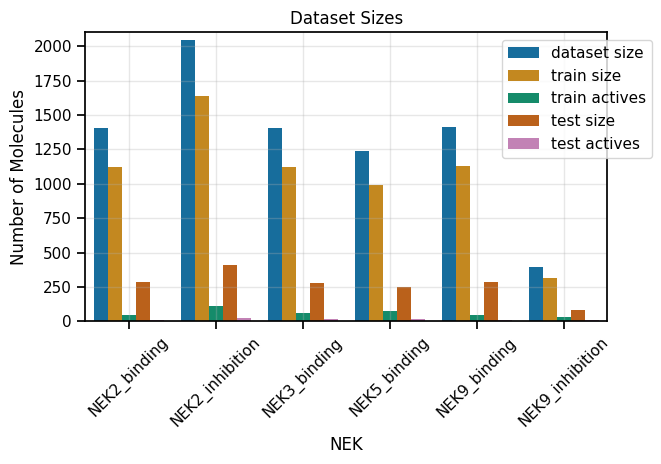

In [318]:
# melted_ratio = pd.melt(ratio_df, id_vars=['dataset','NEK', 'strategy'], value_vars=['train size',
#        'train actives', 'test size', 'test actives', 'dataset size',
#        'train active/train size', 'test active/test size',
#        'train active/total', 'test active/total'], var_name ='Metric', value_name='Value')
ratio_scaled_only = ratio_df[ratio_df['strategy']=='scaled']

melted_ratio = pd.melt(ratio_scaled_only, id_vars=['dataset','NEK', 'strategy'], value_vars=['dataset size','train size',
       'train actives', 'test size', 'test actives'], var_name ='Metric', value_name='Value')
melted_ratio
g3 = sns.barplot(x='NEK', y='Value', hue='Metric', data=melted_ratio,errorbar=None)
plt.xticks(rotation=45)
plt.ylabel('Number of Molecules')
plt.title('Dataset Sizes')
plt.tight_layout()
plt.ylim(0,2100)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.grid(True, alpha=0.3)
plt.savefig('NEK_datasetsize_plot.png')
plt.show();

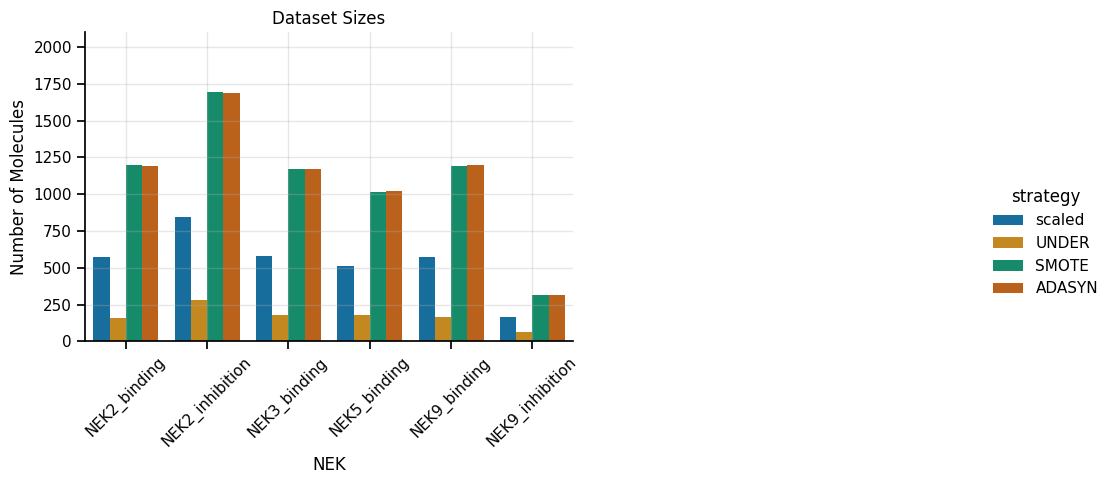

In [267]:
melted_ratio2 = pd.melt(ratio_df, id_vars=['dataset','NEK', 'feat_type', 'strategy'], value_vars=['dataset size','train size',
       'train actives', 'test size', 'test actives'], var_name ='Metric', value_name='Value')
g3 = sns.catplot(melted_ratio2, x='NEK', y='Value', hue='strategy', col='feat_type',  kind='bar', col_wrap=2,errorbar=None)
# g3a = sns.barplot(x='NEK', y='Value', hue='Metric',cols='strategy',rows='feat_type', data=melted_ratio2,errorbar=None)
plt.xticks(rotation=45)
plt.ylabel('Number of Molecules')
plt.title('Dataset Sizes')
plt.tight_layout()
plt.ylim(0,2100)
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.grid(True, alpha=0.3)
plt.show();

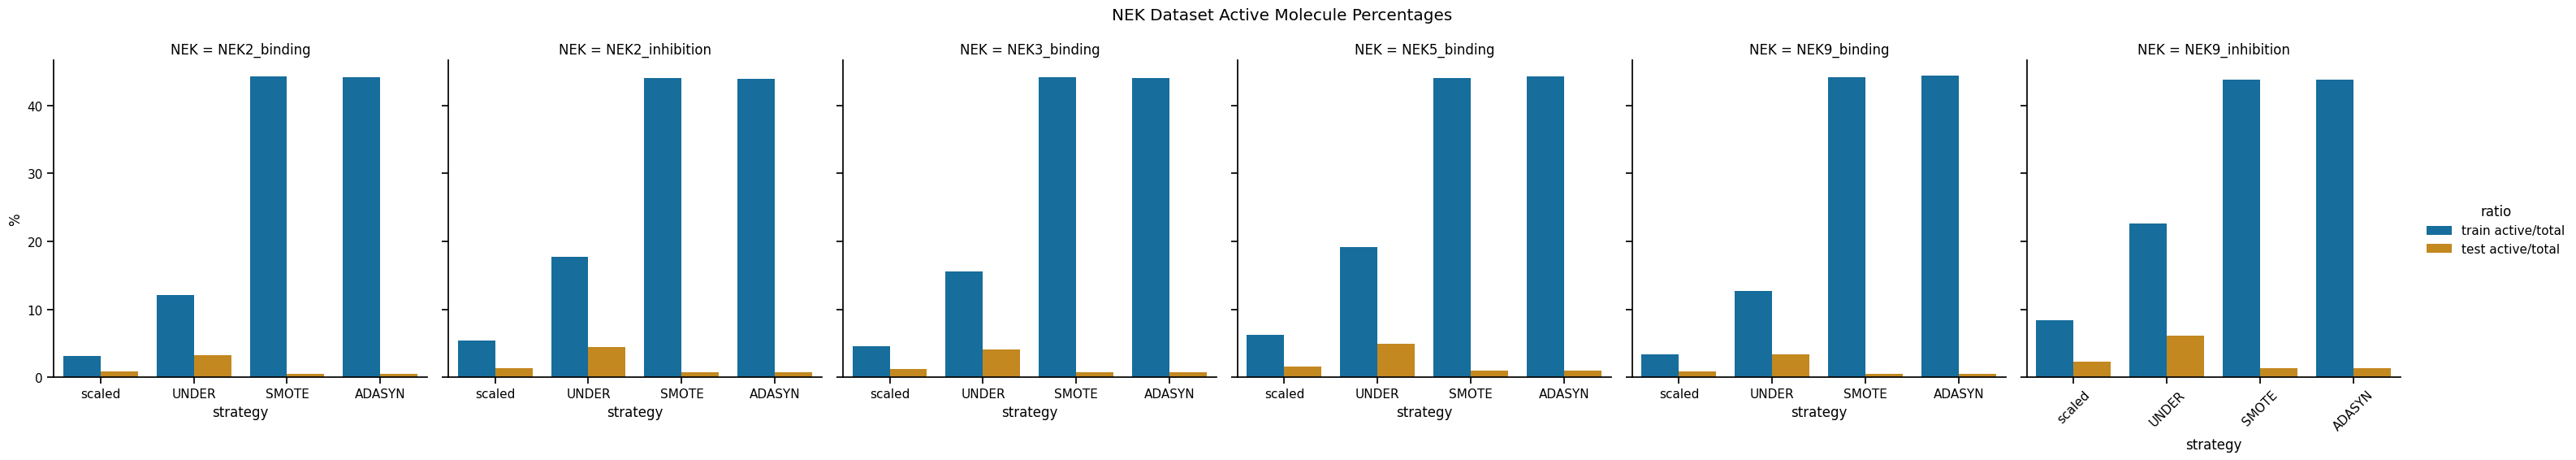

In [301]:
# melted_ratio3 = pd.melt(ratio_df, id_vars=['dataset','NEK', 'feat_type', 'strategy'], value_vars=[
#        'train active/train size', 'test active/test size',
#        'train active/total', 'test active/total'], var_name ='Metric', value_name='Value')
# melted_ratio3 = pd.melt(ratio_df, id_vars=['dataset','NEK', 'feat_type', 'strategy'], value_vars=[
#        'train active/train size', 'test active/test size'], var_name ='Metric', value_name='Value')
melted_ratio3 = pd.melt(ratio_df, id_vars=['dataset','NEK', 'feat_type', 'strategy'], value_vars=[
       'train active/total', 'test active/total'], var_name ='ratio', value_name='%')
g3 = sns.catplot(data=melted_ratio3,x='strategy', y='%',hue='ratio',col='NEK',kind='bar',errorbar=None)
plt.xticks(rotation=45)
plt.ylabel('%')
plt.suptitle('NEK Dataset Active Molecule Percentages',y=1.05)
plt.savefig('ea_NEK_dataset_ratio_plot.png')
plt.show();


# plt.show();

In [287]:
# melted_ratio3 = pd.melt(ratio_df, id_vars=['dataset','NEK', 'feat_type', 'strategy'], value_vars=[
#        'train active/train size', 'test active/test size',
#        'train active/total', 'test active/total'], var_name ='Metric', value_name='Value')
melted_ratio4 = pd.melt(ratio_df, id_vars=['dataset','NEK', 'feat_type', 'strategy'], value_vars=[
       'train active/train size', 'test active/test size'], var_name ='Metric', value_name='Value')

g4 = sns.catplot(data=melted_ratio3,x='strategy', y='%',hue='ratio',col='NEK',kind='bar',errorbar=None)
plt.xticks(rotation=45)
plt.ylabel('%')
plt.title('NEK Dataset Active Molecule Percentages')
plt.savefig('ea_NEK_dataset_ratio_plot.png')
plt.show();


# plt.show();

,dataset,NEK,feat_type,strategy,Metric,Value
0,NEK2_binding_moe_scaled,NEK2_binding,moe,scaled,train active/train size,4.000000
1,NEK2_binding_moe_UNDER,NEK2_binding,moe,UNDER,train active/train size,50.000000
2,NEK2_binding_moe_SMOTE,NEK2_binding,moe,SMOTE,train active/train size,50.000000
3,NEK2_binding_moe_ADASYN,NEK2_binding,moe,ADASYN,train active/train size,49.953661
4,NEK2_inhibition_moe_scaled,NEK2_inhibition,moe,scaled,train active/train size,6.850153
...,...,...,...,...,...,...
91,NEK9_binding_moe_ADASYN,NEK9_binding,moe,ADASYN,test active/total,0.531263
92,NEK9_inhibition_moe_scaled,NEK9_inhibition,moe,scaled,test active/total,2.290076
93,NEK9_inhibition_moe_UNDER,NEK9_inhibition,moe,UNDER,test active/total,6.164384
94,NEK9_inhibition_moe_SMOTE,NEK9_inhibition,moe,SMOTE,test active/total,1.406250


In [299]:
ratio_df.columns

Index(['dataset', 'NEK', 'feat_type', 'strategy', 'train size',
       'train actives', 'test size', 'test actives', 'dataset size',
       'train active/train size', 'test active/test size',
       'train active/total', 'test active/total'],
      dtype='object')

In [322]:
ratio_scaled_only['actives / total'] = ratio_scaled_only['total actives'] / ratio_scaled_only['dataset size']*100

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_85825/354626585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_scaled_only['actives / total'] = ratio_scaled_only['total actives'] / ratio_scaled_only['dataset size']*100


In [323]:
ratio_scaled_only

,dataset,NEK,strategy,train size,train actives,test size,test actives,dataset size,total actives,train active/train size,test active/test size,train active/total,test active/total,train inactive per active,test inactive per active,actives / total
0,NEK2_binding_moe_scaled,NEK2_binding,scaled,1125,45,283,12,1408,57,4.000000,4.240283,3.196023,0.852273,24.000000,22.583333,4.048295
8,NEK2_inhibition_moe_scaled,NEK2_inhibition,scaled,1635,112,409,28,2044,140,6.850153,6.845966,5.479452,1.369863,13.598214,13.607143,6.849315
16,NEK3_binding_moe_scaled,NEK3_binding,scaled,1122,64,282,17,1404,81,5.704100,6.028369,4.558405,1.210826,16.531250,15.588235,5.769231
24,NEK5_binding_moe_scaled,NEK5_binding,scaled,989,77,248,20,1237,97,7.785642,8.064516,6.224737,1.616815,11.844156,11.400000,7.841552
32,NEK9_binding_moe_scaled,NEK9_binding,scaled,1126,48,283,13,1409,61,4.262877,4.593640,3.406671,0.922640,22.458333,20.769231,4.329312
40,NEK9_inhibition_moe_scaled,NEK9_inhibition,scaled,313,33,80,9,393,42,10.543131,11.250000,8.396947,2.290076,8.484848,7.888889,10.687023
